In [1]:
# @title
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import copy
import scipy
from measurements import *
from plotting import *
from mlm import *
import warnings

In [2]:
# @title
# !pip install upsetplot

In [3]:
# @title
warnings.filterwarnings('ignore')
# @title
pd.options.display.max_rows = 1000  # Example: display 60 rows
pd.options.display.max_columns = 1000  # Example: display 60 rows

In [4]:
# @title
raw_data = pd.read_csv('ExplainableAIDeterio_DATA_2025-06-22_2232.csv')

In [5]:
# @title
# shifting the values so that neutral = 0, strong agree = +2, strong disagree = -2
# shiftscaling - raw_data[['initial_r_expimportance', 'post_importance']]
shiftscaling = 3
raw_data['init_importance'] = shiftscaling - raw_data['initial_r_expimportance']
raw_data['post_importance2'] = shiftscaling - raw_data['post_importance']
raw_data['pre_vs_post_importance'] = raw_data['post_importance2'] - raw_data['init_importance']
raw_data['pre_vs_post_importance']


raw_data['unified'] = 'Clinicians'

In [6]:
# @title
# tempdata_5['is_nurse_or_not'] == 'Nurse' //'Physician'
# tempdata_5.shape

In [7]:
# @title
# [pre_post_notnan['post_importance2'][pre_post_notnan['post_importance2'] == x].shape[0] for x in range(-2, 3)]

In [8]:
# @title
# [pre_post_notnan['init_importance'][pre_post_notnan['init_importance'] == x].shape[0] for x in range(-2, 3)]

In [9]:
# @title
likert_scale_fields = [
  'initial_r_expimportance',
  'initial_r_mltrust',
  'post_at_understand',
  'post_cf_understand',
  'post_rb_understand',
  'post_at_changetrust',
  'post_cf_changetrust',
  'post_rb_changetrust',
  'post_at_increaseunderstand',
  'post_cf_increaseunderstand',
  'post_rb_increaseunderstand',
  'post_at_influenceme',
  'post_cf_influenceme',
  'post_rb_influenceme',
  'post_importance',
  'post_rb_length',
  'post_attrib_longshort',
] + [x for x in raw_data.columns if len([z for z in ['understandexp_', 'increasetrust_', 'increaseunderstand_'] if z in x]) > 0]

#adjusting the scale since in the redcap Likert scale, 1=highest, 5=lowest agreement

for fld in likert_scale_fields:
  raw_data[fld] = shiftscaling - raw_data[fld]

In [10]:
# @title
# define columns that the visualizations will be split on
color_on_field_1 = 'is_nurse_or_not'
color_on_field_2 = 'site'

In [11]:
# @title
#limit data to only use the completed records
raw_data = raw_data[raw_data['payment_questions_complete'] == 2]

#rename the categorical role columns to be mroe readable
raw_data = raw_data.rename({
    'demo_current_role___1': 'is_nurse',
    'demo_current_role___2': 'is_rrt',
    'demo_current_role___3': 'is_trainee',
    'demo_current_role___4': 'is_attending',
    'demo_current_role___5': 'is_midlevel'
}, axis=1)

raw_data = raw_data.rename({
    'post_which_types_multiple___1':'Attribution explanations',
    'post_which_types_multiple___2':'Counterfactual explanations',
    'post_which_types_multiple___3':'Rule-based explanations',
}, axis=1)

# add a new column to distinguish between nurse and non-nurse for later analysis
raw_data[color_on_field_1] = np.nan
raw_data[color_on_field_1][raw_data['is_nurse'] == 1] = 'Nurse'
raw_data[color_on_field_1][raw_data['is_nurse'] == 0] = 'Physician'

#add a new column to distinguish between locations for later analysis
raw_data[color_on_field_2] = np.nan
raw_data[color_on_field_2][raw_data['demo_institution'] == 1] = 'UW-Madison'
raw_data[color_on_field_2][raw_data['demo_institution'] == 2] = 'U-Chicago'

In [12]:
# @title
#define hardcoded labels that are used
ordered_qs = [
    'init',
    'first',
    'second',
    'third'
]
agreelist = [
    'Agree strongly (+2)',
    'Agree somewhat (+1)',
    'Neutral (0)',
    'Disagree somewhat (-1)',
    'Disagree strongly (-2)'
]
question_time_mapping = {
    0: {'first':'Attribution', 'second':'Counterfactual', 'third':'Rule-based', 'init':'initial'},
    1: {'first':'Attribution', 'second':'Rule-based', 'third':'Counterfactual', 'init':'initial'},
    2: {'first':'Counterfactual', 'second':'Attribution', 'third':'Rule-based', 'init':'initial'},
    3: {'first':'Counterfactual', 'second':'Rule-based', 'third':'Attribution', 'init':'initial'},
    4: {'first':'Rule-based', 'second':'Counterfactual', 'third':'Attribution', 'init':'initial'},
    5: {'first':'Rule-based', 'second':'Attribution', 'third':'Counterfactual', 'init':'initial'},
}
order_type_mapping = {
    0: {'first':'First', 'second':'Second', 'third':'Third', 'init':'Initial'},
    1: {'first':'First', 'second':'Second', 'third':'Third', 'init':'Initial'},
    2: {'first':'First', 'second':'Second', 'third':'Third', 'init':'Initial'},
    3: {'first':'First', 'second':'Second', 'third':'Third', 'init':'Initial'},
    4: {'first':'First', 'second':'Second', 'third':'Third', 'init':'Initial'},
    5: {'first':'First', 'second':'Second', 'third':'Third', 'init':'Initial'},
}
answer_meaning = {
    1.0: 'Agree strongly',
    2.0: 'Agree somewhat',
    3.0: 'Neutral',
    4.0: 'Disagree somewhat',
    5.0: 'Disagree strongly',
}
question_cols={
    'understandexp': "I understand the explanation of the machine learning model's prediction for this patient case.",
    'increasetrust': "The explanation increases my trust in the machine learning model's predictions.",
    'increaseunderstand': "The explanation increased my understanding of how the machine learning model made a prediction for this patient."
}
gen_cols={
    'post_at_understand': "(Attributions) I understand explanations of this type.",
    'post_cf_understand': "(Counterfactuals) I understand explanations of this type.",
    'post_rb_understand': "(Rule-based) I understand explanations of this type.",
    'post_at_changetrust': "(Attributions) Explanations of this type increased my trust in the machine learning model.",
    'post_cf_changetrust': "(Counterfactuals) Explanations of this type increased my trust in the machine learning model.",
    'post_rb_changetrust': "(Rule-based) Explanations of this type increased my trust in the machine learning model.",
    'post_at_increaseunderstand': "(Attributions) Explanations of this type increased my understanding of how the machine learning model makes predictions for patients.",
    'post_cf_increaseunderstand': "(Counterfactuals) Explanations of this type increased my understanding of how the machine learning model makes predictions for patients.",
    'post_rb_increaseunderstand': "(Rule-based) Explanations of this type increased my understanding of how the machine learning model makes predictions for patients.",
    'post_at_influenceme': "(Attributions) Explanations of this type influenced my selection of which features were most important for determining that a patient was at high risk of clinical deterioration.",
    'post_cf_influenceme': "(Counterfactuals) Explanations of this type influenced my selection of which features were most important for determining that a patient was at high risk of clinical deterioration.",
    'post_rb_influenceme': "(Rule-based) Explanations of this type influenced my selection of which features were most important for determining that a patient was at high risk of clinical deterioration.",
    'post_importance': "Important to see exp",
    'post_rb_length':"Rulebased: Shorter+Concise over Longer+Detailed",
    'post_attrib_longshort':"Attrib: Top features only?",
}
explanations_data = {
    'Q1': {
        'Attribution': ['sbp', 'o2sat', 'lactate', 'fio2', 'resprate', 'heartrate'],
        'Counterfactual': ['heartrate', 'resprate', 'sbp', 'fio2'],
        'Rule-based': ['lactate', 'fio2', 'resprate', 'heartrate', 'braden'],
    },
    'Q2': {
        'Attribution': ['resprate', 'heartrate', 'temperature', 'o2sat', 'disoriented'],
        'Counterfactual': ['heartrate', 'resprate', 'temperature', 'disoriented'],
        'Rule-based': ['resprate', 'fio2'],
    },
    'Q3': {
        'Attribution': ['sbp', 'dbp', 'o2sat', 'resprate', 'creatinine', 'heartrate', 'fio2'],
        'Counterfactual': ['heartrate', 'resprate', 'sbp', 'dbp', 'fio2'],
        'Rule-based': ['fio2', 'heartrate', 'braden_nutrition'],
    },
    'Q4': {
        'Attribution': ['fio2', 'o2sat', 'resprate', 'temperature', 'heartrate'],
        'Counterfactual': ['resprate', 'o2sat', 'fio2'],
        'Rule-based': ['fio2', 'resprate'],
    },
    'Q5': {
        'Attribution': ['resprate', 'fio2', 'avpu', 'heartrate', 'o2sat'],
        'Counterfactual': ['heartrate', 'resprate', 'fio2'],
        'Rule-based': ['fio2', 'resprate'],
    },
}
fields_to_remove = [
    'first_see_',
    'second_see_',
    'third_see_'
]
postfields = [
    'post_at_understand',
    'post_cf_understand',
    'post_rb_understand',
    'post_at_changetrust',
    'post_cf_changetrust',
    'post_rb_changetrust',
    'post_at_increaseunderstand',
    'post_cf_increaseunderstand',
    'post_rb_increaseunderstand',
    'post_at_influenceme',
    'post_cf_influenceme',
    'post_rb_influenceme'
]

In [13]:
# @title
processed_data = get_byquestion_data(
    response_data=raw_data,
    fields_to_remove=fields_to_remove
)

per_question_data = make_per_question_data(
    responsedata=raw_data,
    byQ_data=processed_data,
    q_time_mapping=question_time_mapping,
)

post_survey_general_data = raw_data[['record_id'] + list(gen_cols.keys())]

In [14]:
# @title


In [15]:
# @title
df_scatter = process_change_fields(
    postfields=postfields,
    pq_data=per_question_data,
    data=raw_data,
    color_on_field_1=color_on_field_1,
    color_on_field_2=color_on_field_2,
)

for z in ['ue_at','ue_cf','ue_rb','it_at','it_cf','it_rb','iu_at','iu_cf','iu_rb','in_at','in_cf','in_rb']:
    df_scatter[z] = df_scatter[z].apply(lambda x: np.mean(x))

In [16]:
# @title


In [17]:
# @title
age_map = {
    1: "20-29 years old",
    2: "30-39 years old",
    3: "40-49 years old",
    4: "50-59 years old",
    5: "60-years or older",
}
per_question_data['demo_age_range'] = per_question_data['demo_age_range'].apply(lambda x: age_map[x] if not np.isnan(x) else np.nan)

gender_id_map = {
    0: "Female",
    1: "Male",
    2: "Another gender not listed above",
}
per_question_data['demo_gender'] = per_question_data['demo_gender'].apply(lambda x: gender_id_map[x] if not np.isnan(x) else np.nan)

In [18]:
# @title
random_effect_cols = ['record_id']

fixed_effect_cols = [
    'question_number',
    'question_order',
    'exp_type',
    'is_nurse_or_not', # 'role',
    'site',
    'initial_r_expimportance',
    'initial_r_mltrust',
    'demo_gender',
    'demo_age_range',
]

In [19]:
# @title
# def create_mixed_effects_model(df, fixed_cols, random_cols, target):
#     df_model = df.copy()

#     #  Define the data based on the cols
#     required_cols = fixed_cols + random_cols + [target]

#     # Remove rows with missing values in required cols
#     df_model = df_model.dropna(subset=required_cols)

#     if len(df_model) == 0:
#         raise ValueError("No valid rows remaining after removing missing values")

#     # Fixed effects formula string for statsmodel
#     fixed_formula = f"{target} ~ " + " + ".join(fixed_cols)

#     if len(random_cols) == 1:
#         print(f"Fitting mixed effects model with random intercept for: {random_cols[0]}")
#         model = mixedlm(fixed_formula, df_model, groups=df_model[random_cols[0]])
#         model_result = model.fit()
#         return model, model_result, fixed_formula, df_model
#     else:
#         raise NotImplementedError()

#     return model_results, df_model

In [20]:
# @title
raw_postfields_of_interest = [
    'post_at_influenceme',
    'post_cf_influenceme',
    'post_rb_influenceme',
    'post_at_increaseunderstand',
    'post_cf_increaseunderstand',
    'post_rb_increaseunderstand',
    'post_at_changetrust',
    'post_cf_changetrust',
    'post_rb_changetrust',
    'post_at_understand',
    'post_cf_understand',
    'post_rb_understand',
]
postsurvey_fixed = [
    'role',
    'site',
    'initial_r_expimportance',
    'initial_r_mltrust',
    'demo_gender',
    'demo_age_range',
]
postsurvey_random = ['record_id']
postmultiples = ['post_at_changetrust', 'post_cf_changetrust', 'post_rb_changetrust']

In [21]:
# @title
post_influence_targets = [
    'post_at_influenceme',
    'post_cf_influenceme',
    'post_rb_influenceme',
]
post_influence_header = "Explanations of this type influenced my selection of which features were most important for determining that a patient was at high risk of clinical deterioration."

post_changeunderstand_targets = [
    'post_at_increaseunderstand',
    'post_cf_increaseunderstand',
    'post_rb_increaseunderstand',
]
post_changeunderstand_header = "Explanations of this type increased my understanding of how the machine learning model makes predictions for patients."

post_changetrust_targets = [
    'post_at_changetrust',
    'post_cf_changetrust',
    'post_rb_changetrust',
]
post_changetrust_header = "Explanations of this type increased my trust in the machine learning model."

post_understand_targets = [
    'post_at_understand',
    'post_cf_understand',
    'post_rb_understand',
]
post_understand_header = "I understand explanations of this type."

In [22]:
# @title
#get data for post survey case:
new_records = []

for rid in per_question_data['record_id'].unique():
  new_r = {}

  pq_data_first_item = per_question_data[per_question_data['record_id'] == rid].iloc[0].to_dict()
  for md_field in fixed_effect_cols + random_effect_cols:
    new_r[md_field] = pq_data_first_item[md_field]

  matching_dict = raw_data[raw_data['record_id'] == rid]
  for mch_field in raw_postfields_of_interest:
    # print(f"key: {mch_field} , val: {matching_dict[mch_field].item()}")
    new_r[mch_field] = matching_dict[mch_field].item()

  new_records.append(new_r)

lmm_postsurvey_data = pd.DataFrame(new_records)

In [23]:
# @title
field_sets = [(color_on_field_1, 'Nurse', 'Physician'), (color_on_field_2, 'U-Chicago', 'UW-Madison'), ('unified', 'Clinicans', 'Clinicans')]

In [24]:
# @title
no_exptype_fixed_effects = copy.deepcopy(fixed_effect_cols)
no_exptype_fixed_effects.remove("exp_type")

# Importance: (Before cases presented?) Do clinicians think it is important to have explanations of model predictions?

Pre-survey: "It is important to me to have an explanation of a machine learning model's predictions."

Pre-survey: What factors are related to the intial importance selection ("It is important to me to have an explanation of a machine learning model's predictions.")?

In [25]:
# @title
### Pre-survey Mixed Effects Linear Model (In general/not accounting for explanation type)
### Model Target is initial 'explanations are importabnt' ranking

pre_lmm_random = ['record_id']
pre_lmm_fixed = [
 'site',
 'role',
 'RRT',
 'demo_gender',
 'demo_age_range'
]

target_col = 'initial_r_expimportance'
pre_lmm_extra = ['initial_r_mltrust']
pre_lmm_all_vars = pre_lmm_fixed + pre_lmm_random + pre_lmm_extra

holding_data = []

for rid in per_question_data['record_id'].unique():
    matching = per_question_data[per_question_data['record_id'] == rid].iloc[0]
    holding_data.append(matching[pre_lmm_all_vars + [target_col]])

holding_dataset = pd.concat(holding_data, axis=1).transpose()
holding_dataset['initial_r_expimportance'] = pd.to_numeric(holding_dataset['initial_r_expimportance'], errors='coerce')
holding_dataset['initial_r_mltrust'] = pd.to_numeric(holding_dataset['initial_r_mltrust'], errors='coerce')

pre_lmm_model_1, pre_lmm_result_1, pre_lmm_fixed_formula_1, pre_model_data_1 = create_mixed_effects_model(
    df=holding_dataset,
    fixed_cols=(pre_lmm_fixed+pre_lmm_extra),
    random_cols=pre_lmm_random,
    target=target_col)

pre_lmm_result_1.summary()

Formula is: initial_r_expimportance ~ site + role + RRT + demo_gender + demo_age_range + initial_r_mltrust
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:               MixedLM   Dependent Variable:   initial_r_expimportance
No. Observations:    32        Method:               REML                   
No. Groups:          32        Scale:                0.4299                 
Min. group size:     1         Log-Likelihood:       -37.9093               
Max. group size:     1         Converged:            Yes                    
Mean group size:     1.0                                                    
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          2.295    0.890  2.577 0.010  0.550  4.040
site[T.UW-Madison]                -0.616    0.503 -1.224 0.221 -1.602  0.370
role[T.Nurse]                     -0.530    0.617 -0.860 0.390 -1.738  0.678
role[T.Physician Trainee]         -0.858    0.657 -1.306 0.192 -2.145  0.430
RRT[T.Yes]                        -0.398    0.485 -0.819 0.413 -1.349  0.554
demo_gender[T.Male]                0.175    0.540  0.324 0.746 -0.884  1.235
demo_age_range[T.30-39 years old] -0.275    0.524 -0.524 0.600 -1.302  0.753
demo_age_range[T.40-49 years old] -0.525    0.636 -0.825 0.409 -1.771  0.722
demo_age_range[T.50-59 years old] -0.215    0.818 -0.263 0.792 -1.818  1.388
initial_r_mltrust                  0.202    0.211  0.956 0.339 -0.212  0.615
Group Var                          0.430                                    
============================================================================

"""

# Importance: (After cases presented?) Do clinicians think it is important to have explanations of model predictions?

Comparison Before vs. After: Do clinicians think it is important to have explanations of model predictions?

In [26]:
raw_data[['is_nurse_or_not', 'initial_r_expimportance', 'post_importance']].groupby('is_nurse_or_not').mean()
# raw_data

,initial_r_expimportance,post_importance
is_nurse_or_not,,
Nurse,1.0,1.000000
Physician,1.5,1.888889


In [27]:
# @title
compare_data = raw_data[['record_id', 'initial_r_expimportance', 'post_importance']]
compare_data['post_minus_initial_importance'] = raw_data['post_importance'] - raw_data['initial_r_expimportance']

greatestreduction_to_mostimprovement = np.argsort(compare_data['post_minus_initial_importance'])


r_dat = []
r_pq = []
for rrank in range(0,5):
  rank_to_check = rrank

  rank_rid = compare_data.iloc[greatestreduction_to_mostimprovement[rank_to_check]]['record_id'].item()
  matching = raw_data[raw_data['record_id'] == rank_rid]
  r_dat.append(matching)

  pq_match = per_question_data[per_question_data['record_id'] == rank_rid]
  r_pq.append(pq_match)

r_dat = pd.concat(r_dat)
r_pq = pd.concat(r_pq)

# r_pq.groupby('record_id').mean(numeric_only=True).mean(numeric_only=True)
np.array(r_dat[['initial_t_whatexpshouldbe', 'demo_comments', 'is_nurse', 'demo_institution', 'postsurvey_whatabout_at', 	'postsurvey_whatabout_cf', 	'postsurvey_whatabout_rb', 'post_importance']])

array([['Basic principles with a basic example. ',
        'It was interesting to learn about machine learning logic. ', 1,
        2.0,
        'I like that it provided a "weighted" approach to the various data points to help understand how far they were driving the total risk towards more risk or less risk. I disliked that it was the toughest to decipher and analyze...I believe the more of these alongside each other, the more it could be difficult to manage visually and cognitively.',
        'I liked its visual simplicity, but it was difficult to determine the magnitude of significance for the distance between the factual and counterfactual.',
        "I think I liked the rule-based best because they were concrete assertions on what was triggering the risk indicators. It's a quick format and doesn't take much time to deduce what was driving the risk. ",
        -1.0],
       [nan, nan, 1, 1.0, nan, nan, nan, 0.0],
       ['decompensation ', 'graphs/wording were a bit confusing', 1, 

In [28]:
# @title
#get data for post survey case:
new_records = []

for rid in per_question_data['record_id'].unique():
  new_r = {}

  pq_data_first_item = per_question_data[per_question_data['record_id'] == rid].iloc[0].to_dict()
  for md_field in fixed_effect_cols + random_effect_cols:
    new_r[md_field] = pq_data_first_item[md_field]

  matching_dict = raw_data[raw_data['record_id'] == rid]
  for mch_field in ['post_importance', 'initial_r_expimportance']:
    new_r[mch_field] = matching_dict[mch_field].item()
  new_r['pre_vs_post_importance'] = ( matching_dict['post_importance'].item() - matching_dict['initial_r_expimportance'].item())

  new_records.append(new_r)

lmm_postsurvey_data2 = pd.DataFrame(new_records)

In [29]:
# @title
#IS THIS RIGHT? OR SHOULD WE DROP initial_r_expimportance
target_col = 'post_importance'

temp_fixed_effects = [
    'question_number',
 'question_order',
 'is_nurse_or_not', #'role',
 'site',
 'initial_r_mltrust',
 'demo_gender',
 'demo_age_range',
# 'initial_r_expimportance'
 ]

temp_data = lmm_postsurvey_data2[~lmm_postsurvey_data2[target_col].isna()]#.drop(['initial_r_expimportance'], axis=1)
temp_data = temp_data[temp_fixed_effects + random_effect_cols + [target_col]]
lmm_model_42, lmm_result_42, lmm_fixed_formula_42, model_data_42 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=temp_fixed_effects,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_42.summary()

Formula is: post_importance ~ question_number + question_order + is_nurse_or_not + site + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                 MixedLM      Dependent Variable:      post_importance
No. Observations:      34           Method:                  REML           
No. Groups:            34           Scale:                   0.2427         
Min. group size:       1            Log-Likelihood:          -35.2086       
Max. group size:       1            Converged:               Yes            
Mean group size:       1.0                                                  
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          1.273    0.421  3.025 0.002  0.448  2.098
is_nurse_or_not[T.Physician]       1.141    0.301  3.790 0.000  0.551  1.730
site[T.UW-Madison]                -0.108    0.320 -0.337 0.736 -0.736  0.520
demo_gender[T.Male]               -0.439    0.334 -1.314 0.189 -1.094  0.216
demo_age_range[T.30-39 years old] -0.185    0.349 -0.529 0.597 -0.868  0.499
demo_age_range[T.40-49 years old] -0.451    0.414 -1.090 0.276 -1.263  0.360
demo_age_range[T.50-59 years old] -0.735    0.564 -1.304 0.192 -1.840  0.369
initial_r_mltrust                 -0.062    0.156 -0.398 0.690 -0.368  0.244
Group Var                          0.243                                    
============================================================================

"""

# Trust: Do clinicians trust the predictions of learned models in clinical settings (before cases presented)?

Pre-survey: "In general, I trust the predictions of machine learning models in clinical settings."

Pre-survey: MLM model that considers the factors relevant for the initial trust selection ("In general, I trust the predictions of machine learning models in clinical settings.")

In [30]:
# @title
### Pre-survey Mixed Effects Linear Model
### Model Target is the intial ML model trust ranking

pre_lmm_random = ['record_id']
pre_lmm_fixed = [
 'site',
 'role',
 'RRT',
 'demo_gender',
 'demo_age_range'
]

target_col = 'initial_r_mltrust'
pre_lmm_extra = ['initial_r_expimportance']
pre_lmm_all_vars = pre_lmm_fixed + pre_lmm_random + pre_lmm_extra

holding_data = []

for rid in per_question_data['record_id'].unique():
    matching = per_question_data[per_question_data['record_id'] == rid].iloc[0]
    holding_data.append(matching[pre_lmm_all_vars + [target_col]])

holding_dataset = pd.concat(holding_data, axis=1).transpose()
holding_dataset['initial_r_expimportance'] = pd.to_numeric(holding_dataset['initial_r_expimportance'], errors='coerce')
holding_dataset['initial_r_mltrust'] = pd.to_numeric(holding_dataset['initial_r_mltrust'], errors='coerce')

pre_lmm_model_1, pre_lmm_result_1, pre_lmm_fixed_formula_1, pre_model_data_1 = create_mixed_effects_model(
    df=holding_dataset,
    fixed_cols=(pre_lmm_fixed+pre_lmm_extra),
    random_cols=pre_lmm_random,
    target=target_col)

pre_lmm_result_1.summary()

Formula is: initial_r_mltrust ~ site + role + RRT + demo_gender + demo_age_range + initial_r_expimportance
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                 MixedLM     Dependent Variable:     initial_r_mltrust
No. Observations:      32          Method:                 REML             
No. Groups:            32          Scale:                  0.4211           
Min. group size:       1           Log-Likelihood:         -37.6922         
Max. group size:       1           Converged:              Yes              
Mean group size:       1.0                                                  
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.281    1.004  0.280 0.779 -1.686  2.249
site[T.UW-Madison]                -0.540    0.502 -1.077 0.281 -1.523  0.443
role[T.Nurse]                      0.346    0.616  0.562 0.574 -0.861  1.553
role[T.Physician Trainee]         -0.115    0.674 -0.171 0.864 -1.437  1.207
RRT[T.Yes]                         0.386    0.481  0.804 0.422 -0.556  1.328
demo_gender[T.Male]               -0.071    0.536 -0.132 0.895 -1.121  0.980
demo_age_range[T.30-39 years old]  0.172    0.521  0.329 0.742 -0.849  1.192
demo_age_range[T.40-49 years old]  0.106    0.639  0.165 0.869 -1.146  1.357
demo_age_range[T.50-59 years old] -0.305    0.808 -0.377 0.706 -1.889  1.279
initial_r_expimportance            0.198    0.207  0.956 0.339 -0.208  0.603
Group Var                          0.421                                    
============================================================================

"""

# Trust: Do explanations increase trust?

In general, not accounting for explanation type

In [31]:
# @title
#MLM model for in general increased trust (not accounting for explanation type)
target_col = 'increase_trust_ml_model'
temp_data = per_question_data[~per_question_data[target_col].isna()]
temp_data = temp_data[no_exptype_fixed_effects + random_effect_cols + [target_col]]
lmm_model_4, lmm_result_4, lmm_fixed_formula_4, model_data_4 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=no_exptype_fixed_effects,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_4.summary()

Formula is: increase_trust_ml_model ~ question_number + question_order + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:               MixedLM   Dependent Variable:   increase_trust_ml_model
No. Observations:    510       Method:               REML                   
No. Groups:          34        Scale:                0.3445                 
Min. group size:     15        Log-Likelihood:       -512.9914              
Max. group size:     15        Converged:            Yes                    
Mean group size:     15.0                                                   
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.261    0.519  0.503 0.615 -0.756  1.279
question_number[T.q2]              0.118    0.082  1.431 0.152 -0.043  0.279
question_number[T.q3]             -0.098    0.082 -1.193 0.233 -0.259  0.063
question_number[T.q4]              0.069    0.082  0.835 0.404 -0.092  0.230
question_number[T.q5]              0.059    0.082  0.716 0.474 -0.102  0.220
question_order[T.second]          -0.018    0.064 -0.277 0.782 -0.142  0.107
question_order[T.third]           -0.065    0.064 -1.016 0.309 -0.189  0.060
is_nurse_or_not[T.Physician]      -0.039    0.361 -0.108 0.914 -0.746  0.668
site[T.UW-Madison]                 0.076    0.354  0.215 0.830 -0.618  0.770
demo_gender[T.Male]                0.485    0.360  1.345 0.179 -0.222  1.191
demo_age_range[T.30-39 years old]  0.016    0.382  0.041 0.968 -0.734  0.765
demo_age_range[T.40-49 years old] -0.122    0.447 -0.274 0.784 -0.998  0.754
demo_age_range[T.50-59 years old]  0.316    0.608  0.519 0.604 -0.876  1.508
initial_r_expimportance           -0.136    0.162 -0.841 0.401 -0.453  0.181
initial_r_mltrust                  0.263    0.171  1.543 0.123 -0.071  0.598
Group Var                          0.537    0.277                           
============================================================================

"""

# Trust: Do explanations of each type increase trust (after cases presented)?

Per-Case: "The explanation increases my trust in the machine learning model's predictions."

In [32]:
# @title
## Mixed Effects Linear Model
## Model Target is the the participants selection for the case "The explanation increases my trust in the machine learning model's predictions." -> based on 'increase_trust_ml_model'
target_col = 'increase_trust_ml_model'
temp_data = per_question_data[~per_question_data[target_col].isna()]
temp_data = temp_data[fixed_effect_cols + random_effect_cols + [target_col]]
lmm_model_4, lmm_result_4, lmm_fixed_formula_4, model_data_4 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=fixed_effect_cols,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_4.summary()

Formula is: increase_trust_ml_model ~ question_number + question_order + exp_type + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:               MixedLM   Dependent Variable:   increase_trust_ml_model
No. Observations:    510       Method:               REML                   
No. Groups:          34        Scale:                0.3371                 
Min. group size:     15        Log-Likelihood:       -510.7701              
Max. group size:     15        Converged:            Yes                    
Mean group size:     15.0                                                   
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.395    0.521  0.759 0.448 -0.625  1.416
question_number[T.q2]              0.118    0.081  1.447 0.148 -0.042  0.277
question_number[T.q3]             -0.098    0.081 -1.206 0.228 -0.257  0.061
question_number[T.q4]              0.069    0.081  0.844 0.399 -0.091  0.228
question_number[T.q5]              0.059    0.081  0.723 0.469 -0.101  0.218
question_order[T.second]          -0.023    0.063 -0.368 0.713 -0.147  0.100
question_order[T.third]           -0.083    0.063 -1.318 0.187 -0.207  0.041
exp_type[T.Counterfactual]        -0.170    0.063 -2.697 0.007 -0.294 -0.047
exp_type[T.Rule-based]            -0.207    0.063 -3.277 0.001 -0.331 -0.083
is_nurse_or_not[T.Physician]      -0.039    0.361 -0.108 0.914 -0.746  0.668
site[T.UW-Madison]                 0.076    0.354  0.215 0.830 -0.618  0.770
demo_gender[T.Male]                0.485    0.360  1.345 0.179 -0.222  1.191
demo_age_range[T.30-39 years old]  0.016    0.382  0.041 0.968 -0.734  0.765
demo_age_range[T.40-49 years old] -0.122    0.447 -0.274 0.784 -0.998  0.754
demo_age_range[T.50-59 years old]  0.316    0.608  0.519 0.604 -0.876  1.508
initial_r_expimportance           -0.136    0.162 -0.841 0.401 -0.453  0.181
initial_r_mltrust                  0.263    0.171  1.543 0.123 -0.071  0.598
Group Var                          0.537    0.280                           
============================================================================

"""

Post-survey: "Explanations of this type increased my trust in the machine learning model."

In [33]:
# @title
### Post-survey Mixed Effects Linear Model
### Post survey - Explanations of this type increased my trust in the machine learning model
_ = make_post_mlm(
    local_data=lmm_postsurvey_data,
    cols_to_flatten=post_changetrust_targets,
    fixed_effect_cols=fixed_effect_cols ,
    random_effect_cols=random_effect_cols,
)

Formula is: target_value ~ question_number + question_order + exp_type + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       target_value
No. Observations:       102           Method:                   REML        
No. Groups:             34            Scale:                    0.2638      
Min. group size:        3             Log-Likelihood:           -116.3924   
Max. group size:        3             Converged:                Yes         
Mean group size:        3.0                                                 
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept   

# Trust: Do clinicians intially trust ML models, and does that change after seeing explanations?

# Influence: Do explanations influence interpretation of the cases?

In [34]:
# @title
print(per_question_data[['exp_type', 'any_dif_from_prev']].groupby('exp_type').mean()) #.std(numeric_only=True)
print(per_question_data[['exp_type', 'any_dif_from_prev']].groupby('exp_type').std()) #.std(numeric_only=True)

                any_dif_from_prev
exp_type                         
Attribution              0.810256
Counterfactual           0.543590
Rule-based               0.676923
initial                       NaN
                any_dif_from_prev
exp_type                         
Attribution              1.435879
Counterfactual           1.167382
Rule-based               1.277575
initial                       NaN


In general (for all explanation types/not accounting for explanation type): Any changes from previous ranking

In [35]:
# @title
### Mixed Effects Linear Model (In general/not accounting for explanation type)
### Model Target is the count of ranking changes (i.e. HR at rank 1 to HR at rank 3 = 1 change) -> based on 'any_dif_from_prev'
target_col = 'any_dif_from_prev'
temp_data = per_question_data[~per_question_data[target_col].isna()]
temp_data = temp_data[no_exptype_fixed_effects + random_effect_cols + [target_col]]
lmm_model_1, lmm_result_1, lmm_fixed_formula_1, model_data_1 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=no_exptype_fixed_effects,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_1.summary()

Formula is: any_dif_from_prev ~ question_number + question_order + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                 MixedLM     Dependent Variable:     any_dif_from_prev
No. Observations:      510         Method:                 REML             
No. Groups:            34          Scale:                  1.0189           
Min. group size:       15          Log-Likelihood:         -772.8440        
Max. group size:       15          Converged:              Yes              
Mean group size:       15.0                                                 
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          2.272    0.639  3.555 0.000  1.019  3.525
question_number[T.q2]             -0.627    0.141 -4.439 0.000 -0.904 -0.350
question_number[T.q3]             -0.441    0.141 -3.121 0.002 -0.718 -0.164
question_number[T.q4]             -0.863    0.141 -6.104 0.000 -1.140 -0.586
question_number[T.q5]             -0.637    0.141 -4.509 0.000 -0.914 -0.360
question_order[T.second]          -0.465    0.109 -4.244 0.000 -0.679 -0.250
question_order[T.third]           -0.524    0.109 -4.782 0.000 -0.738 -0.309
is_nurse_or_not[T.Physician]      -0.249    0.441 -0.566 0.572 -1.113  0.614
site[T.UW-Madison]                -0.684    0.433 -1.580 0.114 -1.532  0.164
demo_gender[T.Male]                0.351    0.440  0.797 0.426 -0.512  1.214
demo_age_range[T.30-39 years old] -0.298    0.467 -0.639 0.523 -1.214  0.617
demo_age_range[T.40-49 years old] -0.266    0.546 -0.488 0.626 -1.337  0.804
demo_age_range[T.50-59 years old] -0.143    0.743 -0.192 0.847 -1.599  1.313
initial_r_expimportance            0.022    0.198  0.113 0.910 -0.365  0.410
initial_r_mltrust                 -0.188    0.209 -0.902 0.367 -0.597  0.221
Group Var                          0.768    0.240                           
============================================================================

"""

# Influence: Do explanations of each type influence interpretation of the cases (after cases presented)?

Per-case: Based on counting any changes from the previous ranking

In [36]:
# @title
### Mixed Effects Linear Model
### Model Target is the count of ranking changes (i.e. HR at rank 1 to HR at rank 3 = 1 change) -> based on 'any_dif_from_prev'
target_col = 'any_dif_from_prev'
temp_data = per_question_data[~per_question_data[target_col].isna()]
temp_data = temp_data[fixed_effect_cols + random_effect_cols + [target_col]]
lmm_model_1, lmm_result_1, lmm_fixed_formula_1, model_data_1 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=fixed_effect_cols,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_1.summary()

Formula is: any_dif_from_prev ~ question_number + question_order + exp_type + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                 MixedLM     Dependent Variable:     any_dif_from_prev
No. Observations:      510         Method:                 REML             
No. Groups:            34          Scale:                  1.0045           
Min. group size:       15          Log-Likelihood:         -771.2412        
Max. group size:       15          Converged:              Yes              
Mean group size:       15.0                                                 
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          2.463    0.642  3.834 0.000  1.204  3.722
question_number[T.q2]             -0.627    0.140 -4.471 0.000 -0.903 -0.352
question_number[T.q3]             -0.441    0.140 -3.144 0.002 -0.716 -0.166
question_number[T.q4]             -0.863    0.140 -6.147 0.000 -1.138 -0.588
question_number[T.q5]             -0.637    0.140 -4.541 0.000 -0.912 -0.362
question_order[T.second]          -0.469    0.109 -4.312 0.000 -0.682 -0.256
question_order[T.third]           -0.547    0.109 -5.018 0.000 -0.761 -0.334
exp_type[T.Counterfactual]        -0.308    0.109 -2.824 0.005 -0.521 -0.094
exp_type[T.Rule-based]            -0.237    0.109 -2.172 0.030 -0.451 -0.023
is_nurse_or_not[T.Physician]      -0.249    0.441 -0.566 0.572 -1.113  0.614
site[T.UW-Madison]                -0.684    0.433 -1.580 0.114 -1.532  0.164
demo_gender[T.Male]                0.351    0.440  0.797 0.426 -0.512  1.214
demo_age_range[T.30-39 years old] -0.298    0.467 -0.639 0.523 -1.214  0.617
demo_age_range[T.40-49 years old] -0.266    0.546 -0.488 0.626 -1.337  0.804
demo_age_range[T.50-59 years old] -0.143    0.743 -0.192 0.847 -1.599  1.313
initial_r_expimportance            0.022    0.198  0.113 0.910 -0.365  0.410
initial_r_mltrust                 -0.188    0.209 -0.902 0.367 -0.597  0.221
Group Var                          0.769    0.242                           
============================================================================

"""

In [37]:
# @title
### Post-survey Mixed Effects Linear Model
### Post survey - Explanations of this type influenced my selection of which features were most important for determining that a patient was at high risk of clinical deterioration.
_ = make_post_mlm(
    local_data=lmm_postsurvey_data,
    cols_to_flatten=post_influence_targets,
    fixed_effect_cols=fixed_effect_cols ,
    random_effect_cols=random_effect_cols,
)

Formula is: target_value ~ question_number + question_order + exp_type + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       target_value
No. Observations:       102           Method:                   REML        
No. Groups:             34            Scale:                    0.3948      
Min. group size:        3             Log-Likelihood:           -133.8202   
Max. group size:        3             Converged:                Yes         
Mean group size:        3.0                                                 
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept   

# Influence: By how much did each explanation type affect rankings?

In general (for all explanation types/not accounting for explanation type): Distance from previous ranking

# Explanation Understanding: Do clinicians understand the explanations?

Not accounting for explanation type

In [38]:
# @title
#In general - LMM model
target_col = 'understand_exp'
temp_data = per_question_data[~per_question_data[target_col].isna()]
temp_data = temp_data[no_exptype_fixed_effects + random_effect_cols + [target_col]]
lmm_model_3, lmm_result_3, lmm_fixed_formula_3, model_data_3 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=no_exptype_fixed_effects,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_3.summary()

Formula is: understand_exp ~ question_number + question_order + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                  MixedLM      Dependent Variable:      understand_exp
No. Observations:       510          Method:                  REML          
No. Groups:             34           Scale:                   0.4632        
Min. group size:        15           Log-Likelihood:          -582.9463     
Max. group size:        15           Converged:               Yes           
Mean group size:        15.0                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.834    0.528  1.580 0.114 -0.200  1.869
question_number[T.q2]              0.078    0.095  0.823 0.411 -0.108  0.265
question_number[T.q3]             -0.235    0.095 -2.469 0.014 -0.422 -0.049
question_number[T.q4]             -0.039    0.095 -0.411 0.681 -0.226  0.148
question_number[T.q5]             -0.020    0.095 -0.206 0.837 -0.206  0.167
question_order[T.second]          -0.071    0.074 -0.956 0.339 -0.215  0.074
question_order[T.third]           -0.129    0.074 -1.753 0.080 -0.274  0.015
is_nurse_or_not[T.Physician]       0.418    0.366  1.143 0.253 -0.299  1.134
site[T.UW-Madison]                -0.089    0.359 -0.248 0.804 -0.793  0.615
demo_gender[T.Male]                0.170    0.365  0.464 0.643 -0.547  0.886
demo_age_range[T.30-39 years old] -0.175    0.388 -0.451 0.652 -0.935  0.585
demo_age_range[T.40-49 years old] -0.405    0.453 -0.894 0.371 -1.293  0.483
demo_age_range[T.50-59 years old] -0.211    0.617 -0.341 0.733 -1.419  0.998
initial_r_expimportance           -0.134    0.164 -0.815 0.415 -0.455  0.188
initial_r_mltrust                  0.344    0.173  1.986 0.047  0.004  0.683
Group Var                          0.545    0.246                           
============================================================================

"""

# Explanation Understanding: Do clinicians understand explanations of each type (after cases presented)?

In [39]:
# # @title
# tmp_data[['understand_exp', 'exp_type']].groupby('exp_type').std()

Per-case: "I understand the explanation of the machine learning model's prediction for this patient case."

In [40]:
# @title
per_question_data[['exp_type', 'increase_trust_ml_model', 'understand_exp', 'increase_understand_ml_model']].groupby('exp_type').mean()

,increase_trust_ml_model,understand_exp,increase_understand_ml_model
exp_type,,,
Attribution,0.538462,0.882051,0.737113
Counterfactual,0.374359,0.666667,0.548718
Rule-based,0.297436,0.659794,0.523316
initial,NaN,NaN,NaN


In [41]:
# @title
### Mixed Effects Linear Model
target_col = 'understand_exp'
temp_data = per_question_data[~per_question_data[target_col].isna()]
temp_data = temp_data[fixed_effect_cols + random_effect_cols + [target_col]]
lmm_model_3, lmm_result_3, lmm_fixed_formula_3, model_data_3 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=fixed_effect_cols,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_3.summary()

Formula is: understand_exp ~ question_number + question_order + exp_type + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                  MixedLM      Dependent Variable:      understand_exp
No. Observations:       510          Method:                  REML          
No. Groups:             34           Scale:                   0.4530        
Min. group size:        15           Log-Likelihood:          -580.2177     
Max. group size:        15           Converged:               Yes           
Mean group size:        15.0                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.993    0.530  1.875 0.061 -0.045  2.031
question_number[T.q2]              0.078    0.094  0.832 0.405 -0.106  0.263
question_number[T.q3]             -0.235    0.094 -2.497 0.013 -0.420 -0.051
question_number[T.q4]             -0.039    0.094 -0.416 0.677 -0.224  0.145
question_number[T.q5]             -0.020    0.094 -0.208 0.835 -0.204  0.165
question_order[T.second]          -0.075    0.073 -1.033 0.301 -0.219  0.068
question_order[T.third]           -0.150    0.073 -2.051 0.040 -0.294 -0.007
exp_type[T.Counterfactual]        -0.232    0.073 -3.176 0.001 -0.376 -0.089
exp_type[T.Rule-based]            -0.218    0.073 -2.979 0.003 -0.362 -0.075
is_nurse_or_not[T.Physician]       0.418    0.366  1.143 0.253 -0.299  1.134
site[T.UW-Madison]                -0.089    0.359 -0.248 0.804 -0.793  0.615
demo_gender[T.Male]                0.170    0.365  0.464 0.643 -0.547  0.886
demo_age_range[T.30-39 years old] -0.175    0.388 -0.451 0.652 -0.935  0.585
demo_age_range[T.40-49 years old] -0.405    0.453 -0.894 0.371 -1.293  0.483
demo_age_range[T.50-59 years old] -0.211    0.617 -0.341 0.733 -1.419  0.998
initial_r_expimportance           -0.134    0.164 -0.815 0.415 -0.455  0.188
initial_r_mltrust                  0.344    0.173  1.986 0.047  0.004  0.683
Group Var                          0.546    0.248                           
============================================================================

"""

Post-survey: "I understand explanations of this type."

In [42]:
post_understand_targets

['post_at_understand', 'post_cf_understand', 'post_rb_understand']

In [43]:
# @title
### Post-survey Mixed Effects Linear Model
### Post survey - self reported per explanation type did these explanations increase my understanding of the ML model
_ = make_post_mlm(
    local_data=lmm_postsurvey_data,
    cols_to_flatten=post_understand_targets,
    fixed_effect_cols=fixed_effect_cols ,
    random_effect_cols=random_effect_cols,
)

Formula is: target_value ~ question_number + question_order + exp_type + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       target_value
No. Observations:       100           Method:                   REML        
No. Groups:             34            Scale:                    0.4214      
Min. group size:        1             Log-Likelihood:           -126.9946   
Max. group size:        3             Converged:                Yes         
Mean group size:        2.9                                                 
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept   

# Model Understanding: Do explanations increase understanding? (Of how the ML model works)

Per-case: "The explanation increased my understanding of how the machine learning model made a prediction for this patient."

In [44]:
# @title
### Mixed Effects Linear Model
target_col = 'increase_understand_ml_model'
temp_data = per_question_data[~per_question_data[target_col].isna()]
temp_data = temp_data[fixed_effect_cols + random_effect_cols + [target_col]]
lmm_model_5, lmm_result_5, lmm_fixed_formula_5, model_data_5 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=fixed_effect_cols,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_5.summary()

Formula is: increase_understand_ml_model ~ question_number + question_order + exp_type + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:              MixedLM Dependent Variable: increase_understand_ml_model
No. Observations:   507     Method:             REML                        
No. Groups:         34      Scale:              0.4109                      
Min. group size:    14      Log-Likelihood:     -554.3779                   
Max. group size:    15      Converged:          Yes                         
Mean group size:    14.9                                                    
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.812    0.529  1.535 0.125 -0.225  1.849
question_number[T.q2]              0.099    0.090  1.103 0.270 -0.077  0.276
question_number[T.q3]             -0.195    0.090 -2.165 0.030 -0.371 -0.018
question_number[T.q4]              0.004    0.090  0.049 0.961 -0.172  0.181
question_number[T.q5]              0.067    0.090  0.748 0.454 -0.109  0.244
question_order[T.second]          -0.102    0.070 -1.470 0.142 -0.239  0.034
question_order[T.third]           -0.114    0.070 -1.622 0.105 -0.251  0.024
exp_type[T.Counterfactual]        -0.181    0.070 -2.591 0.010 -0.318 -0.044
exp_type[T.Rule-based]            -0.184    0.070 -2.625 0.009 -0.321 -0.047
is_nurse_or_not[T.Physician]       0.022    0.366  0.061 0.951 -0.694  0.739
site[T.UW-Madison]                -0.027    0.359 -0.074 0.941 -0.731  0.678
demo_gender[T.Male]                0.618    0.366  1.692 0.091 -0.098  1.335
demo_age_range[T.30-39 years old] -0.026    0.388 -0.066 0.947 -0.786  0.735
demo_age_range[T.40-49 years old] -0.475    0.454 -1.047 0.295 -1.364  0.414
demo_age_range[T.50-59 years old]  0.035    0.617  0.057 0.955 -1.174  1.244
initial_r_expimportance           -0.167    0.164 -1.017 0.309 -0.488  0.155
initial_r_mltrust                  0.242    0.173  1.395 0.163 -0.098  0.581
Group Var                          0.549    0.261                           
============================================================================

"""

Post-Survey: "The explanation increased my understanding of how the machine learning model made a prediction for this patient."

In [45]:
# @title
### Post-survey Mixed Effects Linear Model
### Post survey - self reported per explanation type did these explanations increase my understanding of the ML model
_ = make_post_mlm(
    local_data=lmm_postsurvey_data,
    cols_to_flatten=post_changeunderstand_targets,
    fixed_effect_cols=fixed_effect_cols ,
    random_effect_cols=random_effect_cols,
)

Formula is: target_value ~ question_number + question_order + exp_type + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       target_value
No. Observations:       101           Method:                   REML        
No. Groups:             34            Scale:                    0.3577      
Min. group size:        2             Log-Likelihood:           -125.8749   
Max. group size:        3             Converged:                Yes         
Mean group size:        3.0                                                 
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept   

# Preferences: Do clinicians prefer to see multiple types of explanations?

In [46]:
# @title
# ",".join([str(x) for x in range(0,100)])
!pip install upsetplot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=upsetplot-0.9.0-py3-none-any.whl size=24866 sha256=ee8605834e09625ae2a07bfcfcf19efbf71aec8f235594f6dcba182c84fcdc45
  Stored in directory: /root/.cache/pip/wheels/5d/7a/54/1460364da0fe4e17c256b7a28191fa373d81292fcf73a4ddb8
Successfully built upsetplot


In [47]:
def make_upset_plot(my_data, title, color_on=None):

    from upsetplot import plot, from_indicators

    fig1 = plt.figure(figsize=(5, 5)) # You can set the size for each figure independently
    ax1 = fig1.add_subplot(111)

    if color_on:
        ax_bar_plt = sns.countplot(
            x='post_multi_pref',
            data=my_data,
            ax=ax1,
            # palette='viridis',
            hue=color_on,
            palette=HUE_COLORS,
        )
        sns.move_legend(ax_bar_plt, loc='lower right', title=None)
    else:
        ax_bar_plt = sns.countplot(
            x='post_multi_pref',
            data=my_data,
            ax=ax1,
            palette='mako',
            # hue=color_on,
            # palette=HUE_COLORS,
        )
    for p in ax_bar_plt.patches[:4]:
        ax_bar_plt.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=10, color='black')
    ax_bar_plt.set_title('Would you prefer to see multiple types of\nexplanations together for a given patient?', )
    ax_bar_plt.set_ylabel('Count')
    ax_bar_plt.set_xticklabels(['Yes', 'No'])
    ax_bar_plt.set_xlabel('')
    ax_bar_plt.set_xticks([0,1])


    if color_on:
        for x in my_data[color_on].unique():
            subset_data = my_data[my_data[color_on] == x]
            temp_data = subset_data[subset_data['post_multi_pref'] == 1]
            df_bool = temp_data[['Attribution', 'Counterfactual', 'Rule-based']].astype(bool)
            upset_data = from_indicators(df_bool)

            x_color = HUE_COLORS[x]



            fig2 = plt.figure(figsize=(9,9))
            upsetplotfig = plot(upset_data,
                fig=fig2,
                #  subplot_spec=gs[0, 1],
                orientation='horizontal',
                show_counts=True,
                sort_by='-input',
                sort_categories_by='-input',
                facecolor=x_color,
                element_size=50,
                intersection_plot_elements=5,
                subset_size="count",
                )
            upsetplotfig['intersections'].set_ylim(0, 5.1)

            plt.suptitle(f"{x}", fontsize=14, y=1.05)
            plt.ylabel("Intersection Size", fontsize=12)
            # plt.legend(title="")

            plt.tight_layout(rect=[0, 0.03, 1, 0.98])
            plt.show()

    else:
        temp_data = my_data[my_data['post_multi_pref'] == 1]
        df_bool = temp_data[['Attribution', 'Counterfactual', 'Rule-based']].astype(bool)
        upset_data = from_indicators(df_bool)

        fig2 = plt.figure(figsize=(9,9))
        plot(upset_data,
            fig=fig2,
            #  subplot_spec=gs[0, 1],
            orientation='horizontal',
            show_counts=False,
            sort_by='-input',
            sort_categories_by='-input',
            facecolor='blue',
            element_size=50,
            intersection_plot_elements=5,
            subset_size="count",

            )

        plt.suptitle(title, fontsize=14, y=1.05)
        plt.ylabel("Intersection Size", fontsize=12)

        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.show()

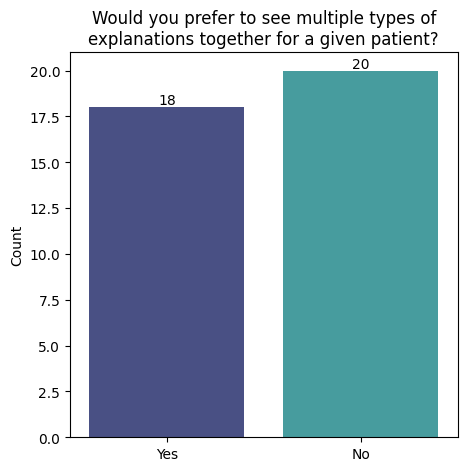

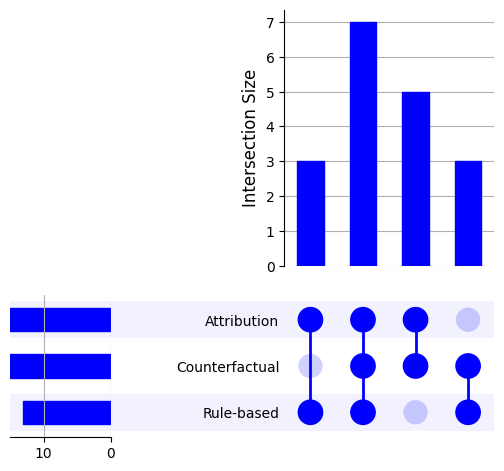

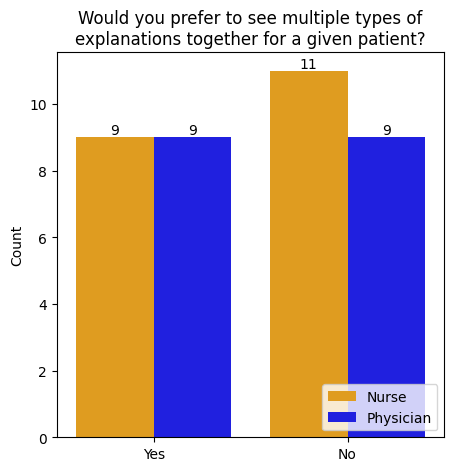

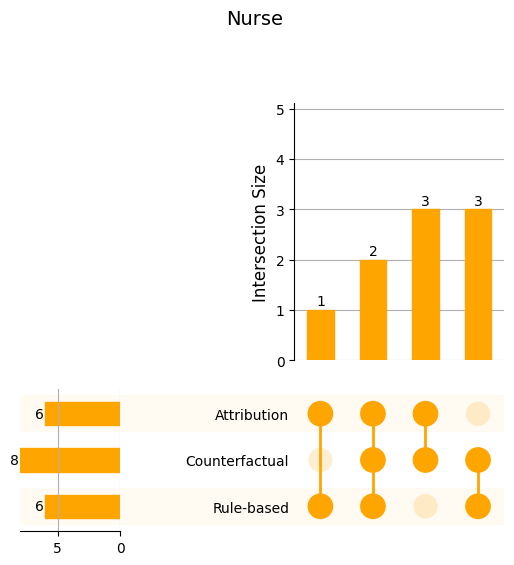

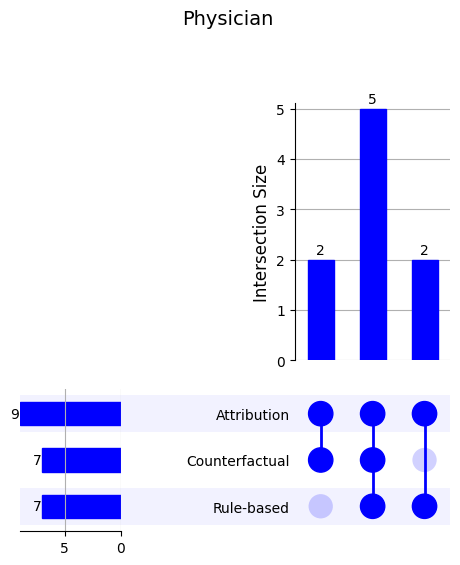

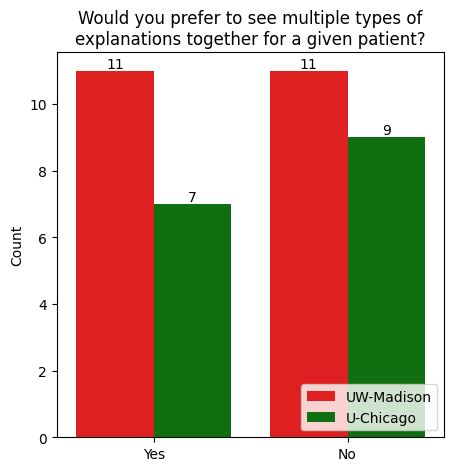

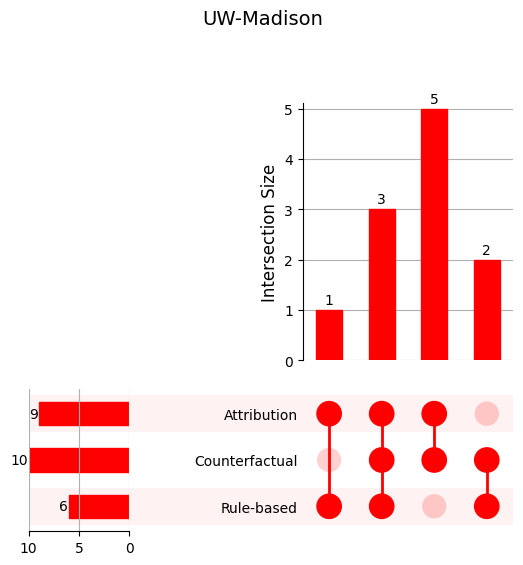

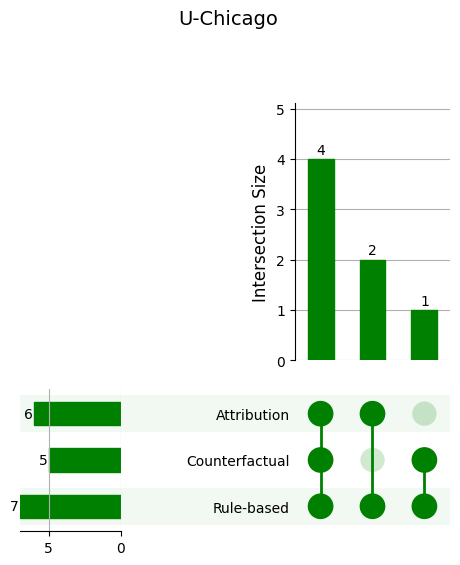

In [48]:
up_data = raw_data.sort_values(by='is_nurse_or_not').rename(columns={'Attribution explanations': 'Attribution', 'Counterfactual explanations': 'Counterfactual', 'Rule-based explanations': 'Rule-based'})

# @title
make_upset_plot(
    up_data,
    title="",#"Upset Plot: For clinicians who say they would like to see multiple\ntypes of explantions together, what combinations do they choose?",
)

make_upset_plot(
    up_data,
    title="",#"Upset Plot: For clinicians who say they would like to see multiple\ntypes of explantions together, what combinations do they choose?",
    color_on=color_on_field_1)

make_upset_plot(
    up_data,
    title="",#"Upset Plot: For clinicians who say they would like to see multiple\ntypes of explantions together, what combinations do they choose?",
    color_on=color_on_field_2)

# Preferences: For rule-based explanations, do they prefer shorter vs. longer explanations?

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_annotated_countplot(temp_df, x_col, color_on_field, title):
    # Set the figure size for better readability
    plt.figure(figsize=(5, 5))

    # Create the count plot using seaborn
    # The 'hue' parameter automatically handles the two-color requirement
    ax = sns.countplot(
        x=x_col,
        hue=color_on_field,
        palette=HUE_COLORS,
        data=temp_df,
        order=[-2, -1, 0, 1, 2],
        hue_order=['Nurse', 'Physician']
    )
    sns.move_legend(ax, title="", loc='upper left')
    # Loop through the bars (patches) to add the count annotations
    for p in ax.patches:
        # Get the height of the bar (which is the count)
        height = p.get_height()

        # Add the text annotation
        if height > 0:
            ax.annotate(f'{int(height)}',  # The text to display
                        (p.get_x() + p.get_width() / 2., height),  # The (x, y) position
                        ha='center', va='center',
                        xytext=(0, 5),  # Offset the text 5 points vertically
                        textcoords='offset points')

    # Customize the plot
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('Count')
    # Create a cleaner default x-axis label from the column name
    ax.set_xlabel(x_col.replace('_', ' ').title())
    ax.set_xticklabels(['Agree\nstrongly','Agree\nsomewhat','Neutral','Disagree\nsomewhat','Disagree\nstrongly'][::-1])
    ax.set_xlabel('')
    # Display the plot
    plt.show()

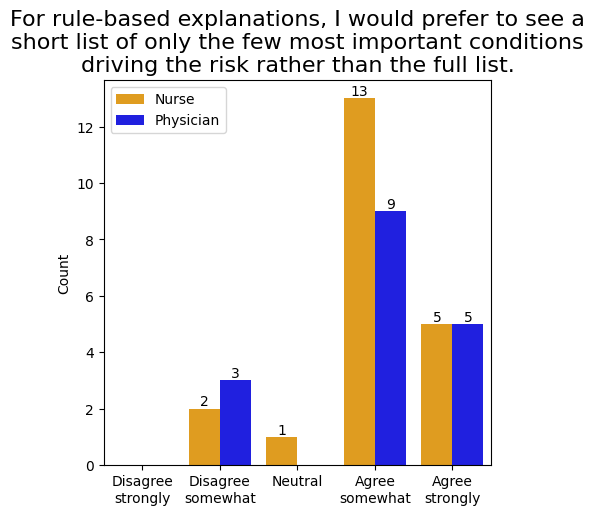

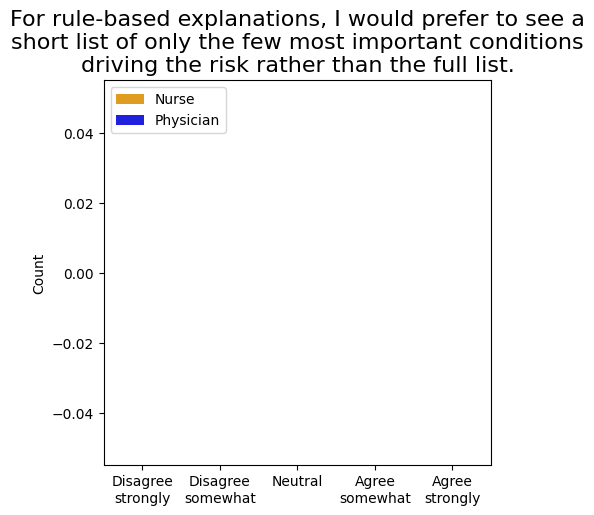

In [50]:
ff1 = 'post_rb_length'
for c in [color_on_field_1, color_on_field_2]:

    countp_data = copy.deepcopy(raw_data)
    clean_series = countp_data[[c, ff1]].replace([np.inf, -np.inf], np.nan).dropna()
    clean_series = clean_series.sort_values(by=c)
    clean_series[ff1] = clean_series[ff1].astype(int)

    create_annotated_countplot(
        temp_df=clean_series,
        x_col=ff1,
        color_on_field=c,
        title="For rule-based explanations, I would prefer to see a\nshort list of only the few most important conditions\ndriving the risk rather than the full list."
      )

In [51]:
# @title
fe_cols = ['role',
 'site',
 'initial_r_expimportance',
 'initial_r_mltrust',
 'demo_gender',
 'demo_age_range']

target_col = 'post_rb_length'
temp_data = per_question_data[~per_question_data[target_col].isna()]
temp_data = temp_data[fe_cols + random_effect_cols + [target_col]]
lmm_model_5, lmm_result_5, lmm_fixed_formula_5, model_data_5 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=fe_cols,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_5.summary()

Formula is: post_rb_length ~ role + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                  MixedLM      Dependent Variable:      post_rb_length
No. Observations:       640          Method:                  REML          
No. Groups:             32           Scale:                   0.0000        
Min. group size:        20           Log-Likelihood:          7199.4097     
Max. group size:        20           Converged:               Yes           
Mean group size:        20.0                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          1.021    0.206  4.962 0.000  0.618  1.424
role[T.Nurse]                     -0.350    0.120 -2.924 0.003 -0.584 -0.115
role[T.Physician Trainee]          0.393    0.141  2.793 0.005  0.117  0.669
site[T.UW-Madison]                 0.542    0.104  5.196 0.000  0.337  0.746
demo_gender[T.Male]               -0.857    0.113 -7.615 0.000 -1.077 -0.636
demo_age_range[T.30-39 years old]  0.221    0.103  2.148 0.032  0.019  0.423
demo_age_range[T.40-49 years old]  0.153    0.133  1.151 0.250 -0.107  0.413
demo_age_range[T.50-59 years old] -0.646    0.162 -3.985 0.000 -0.964 -0.329
initial_r_expimportance           -0.241    0.044 -5.533 0.000 -0.327 -0.156
initial_r_mltrust                  0.204    0.044  4.613 0.000  0.117  0.290
Group Var                          0.037 1331.367                           
============================================================================

"""

# Preferences: For attribution explanations, do they prefer shorter vs. longer explanations?

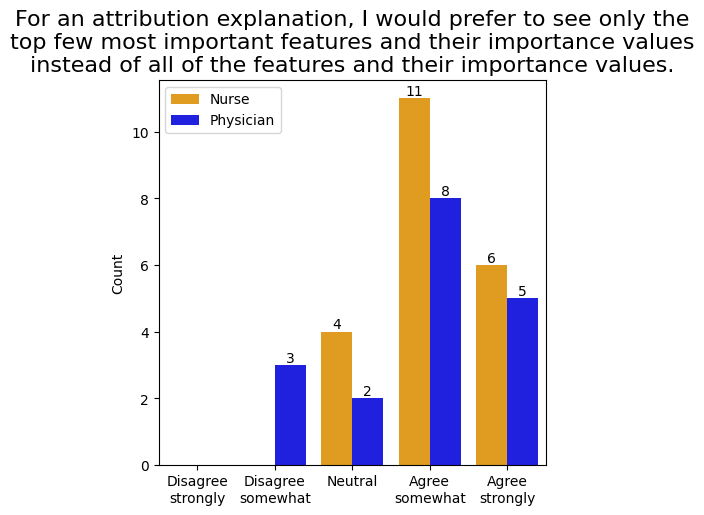

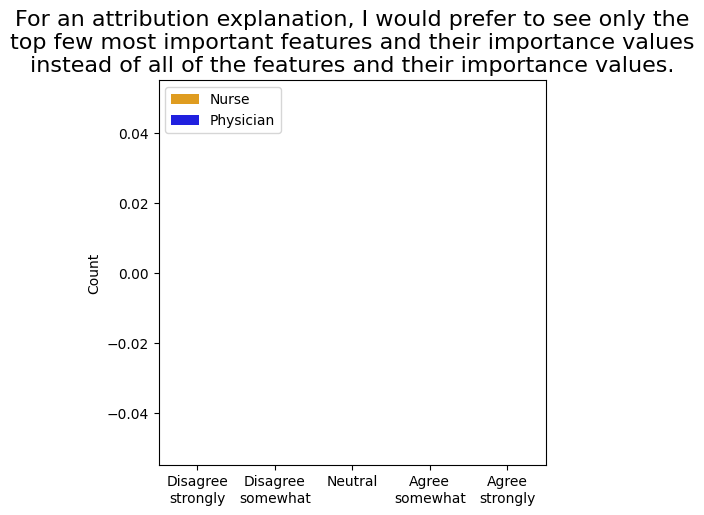

In [52]:
# # @title
# temp_data2 = copy.deepcopy(raw_data)
# # temp_data2['post_attrib_longshort'] = shiftscaling - temp_data2['post_attrib_longshort']
# for c in [color_on_field_1, color_on_field_2]:
#     make_single_bar(temp_data2, col_name='post_attrib_longshort', color_on=c, ncols=7,
#                    title="For an attribution explanation, I would prefer to see only\nthe top few most important features
#                    and their importance values\ninstead of all of the features and their importance values.")


ff1 = 'post_attrib_longshort'
for c in [color_on_field_1, color_on_field_2]:

    countp_data = copy.deepcopy(raw_data)
    clean_series = countp_data[[c, ff1]].replace([np.inf, -np.inf], np.nan).dropna()
    clean_series = clean_series.sort_values(by=c)
    clean_series[ff1] = clean_series[ff1].astype(int)

    create_annotated_countplot(
        temp_df=clean_series,
        x_col=ff1,
        color_on_field=c,
        title="For an attribution explanation, I would prefer to see only the\n"\
              "top few most important features and their importance values\n"\
              "instead of all of the features and their importance values."
      )

In [53]:
# @title
### Mixed Effects Linear Model

fe_cols = ['role',
 'site',
 'initial_r_expimportance',
 'initial_r_mltrust',
 'demo_gender',
 'demo_age_range']

target_col = 'post_attrib_longshort'
temp_data = per_question_data[~per_question_data[target_col].isna()]
temp_data = temp_data[fe_cols + random_effect_cols + [target_col]]
lmm_model_5, lmm_result_5, lmm_fixed_formula_5, model_data_5 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=fe_cols,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_5.summary()

Formula is: post_attrib_longshort ~ role + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:               MixedLM    Dependent Variable:    post_attrib_longshort
No. Observations:    640        Method:                REML                 
No. Groups:          32         Scale:                 0.0000               
Min. group size:     20         Log-Likelihood:        7239.4680            
Max. group size:     20         Converged:             Yes                  
Mean group size:     20.0                                                   
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          1.449    0.193  7.505 0.000  1.071  1.828
role[T.Nurse]                     -0.223    0.112 -1.988 0.047 -0.443 -0.003
role[T.Physician Trainee]          0.036    0.132  0.275 0.783 -0.222  0.295
site[T.UW-Madison]                 0.151    0.098  1.542 0.123 -0.041  0.343
demo_gender[T.Male]               -0.588    0.106 -5.565 0.000 -0.795 -0.381
demo_age_range[T.30-39 years old] -0.514    0.097 -5.318 0.000 -0.703 -0.324
demo_age_range[T.40-49 years old] -0.095    0.125 -0.765 0.444 -0.340  0.149
demo_age_range[T.50-59 years old] -0.981    0.152 -6.445 0.000 -1.279 -0.683
initial_r_expimportance           -0.008    0.041 -0.184 0.854 -0.088  0.073
initial_r_mltrust                  0.003    0.041  0.082 0.935 -0.078  0.085
Group Var                          0.033 1249.347                           
============================================================================

"""

POST ANALYSIS

In [54]:
# @title
color_on = 'is_nurse_or_not'
HUE_COLORS = {
    'Nurse':'orange', 'Physician':'blue',
    'UW-Madison': 'red', 'U-Chicago': 'green',
    'Clinicians': '#437bb6'}

def create_seaborn_boxplot(
    df: pd.DataFrame,
    col_recid='record_id',
    col_val='initial_r_expimportance',
    col_exptype='exp_type',
    divide_by_explanation_type: bool = False,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    ylim: tuple = None,
    xticklabels=None,
    xticks=None,
    yticklabels=None,
    yticks=None,
):
    # --- Style Setup for Nature Journal Guidelines ---
    sns.set_style("ticks")
    # sns.set_context("paper", font_scale=1.3)
    # neutral_color = "#616161" # A neutral, professional gray

    # --- Main Plotting Logic ---
    if divide_by_explanation_type:
        # Use seaborn.catplot for easy creation of faceted plots
        g = sns.catplot(
            data=df,
            x=col_recid,
            y=col_val,
            col=col_exptype,
            kind='box',
            # color=neutral_color,
            height=5,
            aspect=0.9,
            width=0.5,
            hue=color_on,
            palette=HUE_COLORS,
            showfliers=False
            # legend=False
        )

        # Customize the figure and axes from the FacetGrid object
        fig = g.fig
        axes = g.axes.flatten()
        # leg = g.legend

        # Set labels and titles
        g.set_axis_labels(xlabel, ylabel)
        if xticks: g.set(xticks=xticks)
        if xticklabels: g.set_xticklabels(xticklabels, rotation=45, ha='right')
        if yticks: g.set(yticks=yticks)
        if yticklabels: g.set_yticklabels(yticklabels)

        for ax, exp_type in zip(axes, g.col_names):
            ax.set_title(exp_type) # Set individual subplot titles
        # axes[-1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


        if title:
             fig.suptitle(title, y=1.03, fontsize=16)

    else: # Single aggregated plot
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.boxplot(
            data=df,
            x=col_recid,
            y=col_val,
            ax=ax,
            # color=neutral_color,
            fliersize=2, # Make outlier markers smaller
            width=0.5,
            hue=color_on,
            palette=HUE_COLORS,
            # legend=False
        )

        # Customize the single plot
        ax.set_title(title or "Overall Score Distribution")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', rotation=45)
        # plt.setp(ax.get_xticklabels(), ha='right') # Ensure labels don't overlap axis

        if xticks: g.set(xticks=xticks)
        if xticklabels: g.set_xticklabels(xticklabels, rotation=45, ha='right')

        if yticks: g.set(yticks=yticks)
        if yticklabels: g.set_yticklabels(yticklabels)

        # ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        axes = [ax]

    # --- Final Adjustments ---
    # sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Role')
    # sns.legend(title='Role')


    # --- Legend and Mean Line Handling ---
    if divide_by_explanation_type:
        # 1. Get original handles/labels from the auto-generated Seaborn legend
        og_handles = g.legend.legend_handles
        og_labels = [t.get_text() for t in g.legend.get_texts()]

        # 2. Draw mean lines and create proxy artists for the new legend entries
        mean_handles = []
        mean_labels = []
        exp_types = g.col_names
        roles = df[color_on].unique()

        for ax, exp_type in zip(axes, exp_types):
            for role in roles:
                # Calculate mean for the specific group
                mean_val = df[(df[col_exptype] == exp_type) & (df[color_on] == role)][col_val].mean()
                ax.axhline(mean_val, color=HUE_COLORS[role], linestyle='--', linewidth=2)

        # Create proxy artists just for the legend (prevents duplicates)
        for role in roles:
             mean_handles.append(plt.Line2D([0], [0], color=HUE_COLORS[role], linestyle='--', linewidth=2))
             mean_labels.append(f'{role} Mean')

        # 3. Remove the old Seaborn legend
        g.legend.remove()

        # 4. Create a new, single, combined legend on the figure
        g.fig.legend(
            title='Legend',
            handles=og_handles + mean_handles,
            labels=og_labels + mean_labels,
            bbox_to_anchor=(0.9, 1),
            loc='upper left'
        )

    return fig, axes

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Make sure these are defined in your script
color_on = 'is_nurse_or_not'
HUE_COLORS = {
    'Nurse': 'orange', 'Physician': 'blue',
    'UW-Madison': 'red', 'U-Chicago': 'green',
    'Clinicians': '#437bb6'
}

circle_mod = 70
size_base = 0.75
text_shifter = -0.1
circ_text_size = 8

def create_dotstrip_plot(
    df: pd.DataFrame,
    col_recid='record_id',
    col_val='initial_r_expimportance',
    col_exptype='exp_type',
    divide_by_explanation_type: bool = False,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    ylim: tuple = None,
    xticklabels=None,
    xticks=None,
    yticklabels=None,
    yticks=None,
    heightoverride=2,
    aspectoverride=4,
    show_mean_val=False,
):
    """
    Creates a plot with vertical lines showing the range of responses and
    sized circles showing the frequency of each response value.
    """
    # --- Style Setup ---
    sns.set_style("ticks")

    # --- Main Plotting Logic ---
    if divide_by_explanation_type:
        # 1. Pre-process data to get counts for sizing the dots
        counts_df = df.groupby([col_recid, col_exptype, color_on, col_val]).size().reset_index(name='count')
        counts_df['size'] = np.power(counts_df['count'], size_base) * circle_mod

        # 2. Create the FacetGrid to manage subplots and hues
        # g = sns.FacetGrid(df, col=col_exptype, hue=color_on, palette=HUE_COLORS, height=5, aspect=1.5, sharey=True)
        g = sns.FacetGrid(df, row=col_exptype, hue=color_on, palette=HUE_COLORS, height=heightoverride, aspect=aspectoverride, sharey=True)

        group_means = df.groupby([col_exptype, color_on])[col_val].mean()

        # 3. Iterate through each subplot to draw custom elements
        for ax, exp_type in zip(g.axes.flat, g.row_names):
            sub_df = df[df[col_exptype] == exp_type]
            sub_counts_df = counts_df[counts_df[col_exptype] == exp_type]

            # x_order = sorted(sub_df[col_recid].unique())
            x_order = temp_data.groupby(col_recid)[col_val].mean().sort_values(ascending=False).index.tolist()
            print(f"x_order: {x_order}")
            x_map = {name: i for i, name in enumerate(x_order)}
            hue_order = sorted(sub_df[color_on].unique())

            for hue_name in hue_order:
                # Look up the pre-calculated mean
                mean_val = group_means.loc[exp_type, hue_name]
                ax.axhline(
                    y=mean_val,
                    color=HUE_COLORS[hue_name],
                    linestyle='--',
                    linewidth=2,
                    zorder=1 # Draw lines behind the dots
                )

            for x_name in x_order:
                for hue_name in hue_order:
                    group_df = sub_df[(sub_df[col_recid] == x_name) & (sub_df[color_on] == hue_name)]
                    if group_df.empty:
                        continue

                    # Calculate positions with "dodge" to separate hues
                    x_pos_base = x_map[x_name]
                    hue_idx = hue_order.index(hue_name)
                    dodge = (hue_idx - (len(hue_order) - 1) / 2) * 0.4
                    x_pos = x_pos_base + text_shifter

                    # print(f"x_pos: {x_pos}")

                    # a) Draw the thin vertical line for the range
                    min_val, max_val = group_df[col_val].min(), group_df[col_val].max()
                    ax.vlines(x=x_pos, ymin=min_val, ymax=max_val, color=HUE_COLORS[hue_name], lw=1.5, alpha=0.6)

                    # b) Draw the sized dots
                    group_counts = sub_counts_df[(sub_counts_df[col_recid] == x_name) & (sub_counts_df[color_on] == hue_name)]
                    ax.scatter(
                        x=[x_pos] * len(group_counts),
                        y=group_counts[col_val],
                        s=group_counts['size'],
                        color=HUE_COLORS[hue_name],
                        edgecolor='white',
                        zorder=3
                    )
                    for _, row in group_counts.iterrows():
                      if row['count'] > 1:
                          ax.text(
                              x=x_pos,
                              y=row[col_val],
                              s=str(row['count']), # The text is the count
                              ha='center',        # Horizontal alignment
                              va='center',        # Vertical alignment
                              color='white',
                              fontsize=circ_text_size,
                              fontweight='bold'
                          )


            if show_mean_val:
                mean_val_handles = []

                # Get the roles present in this specific subplot
                hue_order_subplot = sorted(sub_df[color_on].unique())

                for role in hue_order_subplot:
                    # Get the mean and create the label with its value
                    mean_value = group_means.loc[exp_type, role]
                    label = f"{role} Mean: {mean_value:.2f}"

                    # Create the visible handle (a colored dashed line)
                    handle = Line2D([0], [0],
                                    color=HUE_COLORS[role],
                                    linestyle='--',
                                    linewidth=2,
                                    label=label)
                    mean_val_handles.append(handle)

                # Create the legend on the current subplot axis
                ax.legend(handles=mean_val_handles, loc='upper right', fontsize='small', bbox_to_anchor=(1.07, 1.25))

            # Configure x-axis for the subplot
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticklabels)
            ax.set_ylim(ylim)

        # --- Final Figure-Level Adjustments ---
        fig = g.fig
        axes = g.axes.flatten()
        g.set_axis_labels(xlabel, ylabel)
        # g.add_legend(title=color_on)

        for ax, exp_type_title in zip(axes, g.row_names):
            ax.set_title(exp_type_title, fontweight='bold')

        if title:
            fig.suptitle(title, y=1.1, fontsize=16)

    else:
        # This creates the same plot but for a single figure (not faceted)
        fig, ax = plt.subplots(figsize=(12, 6))
        counts_df = df.groupby([col_recid, color_on, col_val]).size().reset_index(name='size')
        counts_df['size'] *= circle_mod

        # x_order = sorted(df[col_recid].unique())
        x_order = temp_data.groupby(col_recid)[col_val].mean().sort_values(ascending=False).index.tolist()
        x_map = {name: i for i, name in enumerate(x_order)}
        hue_order = sorted(df[color_on].unique())

        for x_name in x_order:
            for hue_name in hue_order:
                group_df = df[(df[col_recid] == x_name) & (df[color_on] == hue_name)]
                if group_df.empty: continue

                x_pos_base = x_map[x_name]
                hue_idx = hue_order.index(hue_name)
                dodge = (hue_idx - (len(hue_order) - 1) / 2) * 0.4
                x_pos = x_pos_base + text_shifter
                print(f"x_pos: {x_pos}")
                min_val, max_val = group_df[col_val].min(), group_df[col_val].max()
                ax.vlines(x=x_pos, ymin=min_val, ymax=max_val, color=HUE_COLORS[hue_name], lw=1.5, alpha=0.6)

                group_counts = counts_df[(counts_df[col_recid] == x_name) & (counts_df[color_on] == hue_name)]
                ax.scatter(
                    x=[x_pos] * len(group_counts), y=group_counts[col_val],
                    s=group_counts['size'], color=HUE_COLORS[hue_name],
                    edgecolor=HUE_COLORS[hue_name], zorder=3, label=hue_name if x_name == x_order[0] else ""
                )
                for _, row in group_counts.iterrows():
                  if row['count'] > 1:
                      ax.text(
                          x=x_pos,
                          y=row[col_val],
                          s=str(row['count']), # The text is the count
                          ha='center',        # Horizontal alignment
                          va='center',        # Vertical alignment
                          color='white',
                          fontsize=circ_text_size,
                          fontweight='bold'
                      )

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        ax.set_title(title, pad=20)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        # Manually create legend for single plot
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        # ax.legend(by_label.values(), by_label.keys(), title=color_on)
        axes = [ax]



    # --- Legend Creation ---
    # 1. Create handles for the main visual legend
    color_handles = [
        mpatches.Patch(color=HUE_COLORS['Nurse'], label='Nurse'),
        mpatches.Patch(color=HUE_COLORS['Physician'], label='Physician'),
    ]
    size_handles = [
        Line2D([0], [0], marker='o', color='grey', linestyle='None', markersize=np.sqrt(1*40), label='1 Response'),
        Line2D([0], [0], marker='o', color='grey', linestyle='None', markersize=np.sqrt(3*40), label='3 Responses'),
        Line2D([0], [0], marker='o', color='grey', linestyle='None', markersize=np.sqrt(5*40), label='5 Responses')
    ]
    mean_handles = [
        Line2D([0], [0], color=HUE_COLORS['Nurse'], linestyle='--', linewidth=2, label='Nurse Mean'),
        Line2D([0], [0], color=HUE_COLORS['Physician'], linestyle='--', linewidth=2, label='Physician Mean'),
    ]

    # 2. Combine handles and create the main legend
    all_handles = color_handles + mean_handles + size_handles
    if divide_by_explanation_type:
        main_legend = fig.legend(
            handles=all_handles,
            bbox_to_anchor=(1.05, 0.95), # Position for main legend
            loc='upper left',
            # title="Legend"
        )
        # Add the main legend back to the figure so it's not removed
        fig.add_artist(main_legend)

    else: # For single plots, attach the single main legend to the axis
        ax.legend(
            handles=all_handles,
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            # title="Legend"
        )

    return fig, axes

In [123]:
# list(per_question_data.columns)
# [x for x in range(-2, 3)]
# per_question_data['is_nurse_or_not']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches # Needed for custom legends
from matplotlib.lines import Line2D     # Needed for custom legends

In [124]:
ral = [
    'Disagree\nstrongly',
    'Disagree\nsomewhat',
    'Neutral',
    'Agree\nsomewhat',
    'Agree\nstrongly'
 ]

x_order: [-66, -36, -57, -62, -65, -40, -25, -1, -55, -60, -7, -20, -27, -33, -44, -18, -30, -45, -48, -15, -2, -5, -34, -11, -61, -6, -4, -54, -3, -28, -46, -9, -12, -37, -21, -19, -63, -39, -38]
x_order: [-66, -36, -57, -62, -65, -40, -25, -1, -55, -60, -7, -20, -27, -33, -44, -18, -30, -45, -48, -15, -2, -5, -34, -11, -61, -6, -4, -54, -3, -28, -46, -9, -12, -37, -21, -19, -63, -39, -38]
x_order: [-66, -36, -57, -62, -65, -40, -25, -1, -55, -60, -7, -20, -27, -33, -44, -18, -30, -45, -48, -15, -2, -5, -34, -11, -61, -6, -4, -54, -3, -28, -46, -9, -12, -37, -21, -19, -63, -39, -38]
x_order: [-36, -60, -62, -40, -33, -44, -18, -65, -55, -30, -11, -45, -15, -5, -54, -61, -34, -46, -12, -6, -48, -9, -2, -37, -21, -66, -7, -3, -57, -25, -27, -19, -4, -1, -20, -28, -39, -63, -38]
x_order: [-36, -60, -62, -40, -33, -44, -18, -65, -55, -30, -11, -45, -15, -5, -54, -61, -34, -46, -12, -6, -48, -9, -2, -37, -21, -66, -7, -3, -57, -25, -27, -19, -4, -1, -20, -28, -39, -63, -38]
x_order: [-36, 

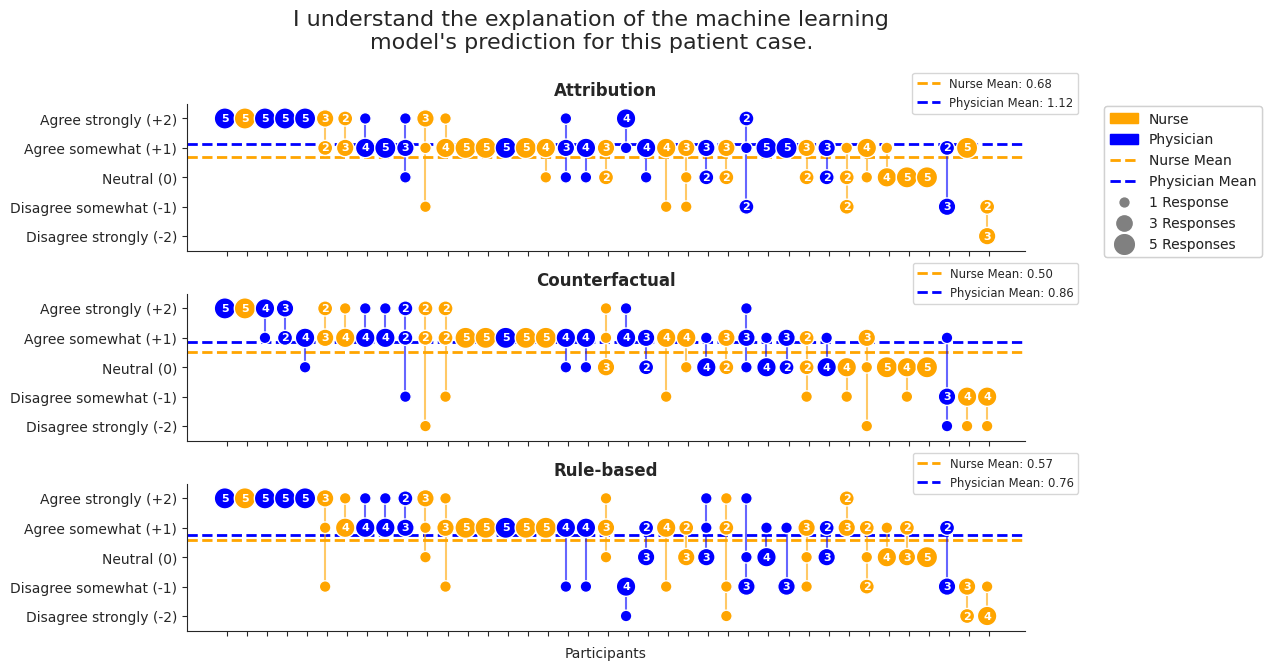

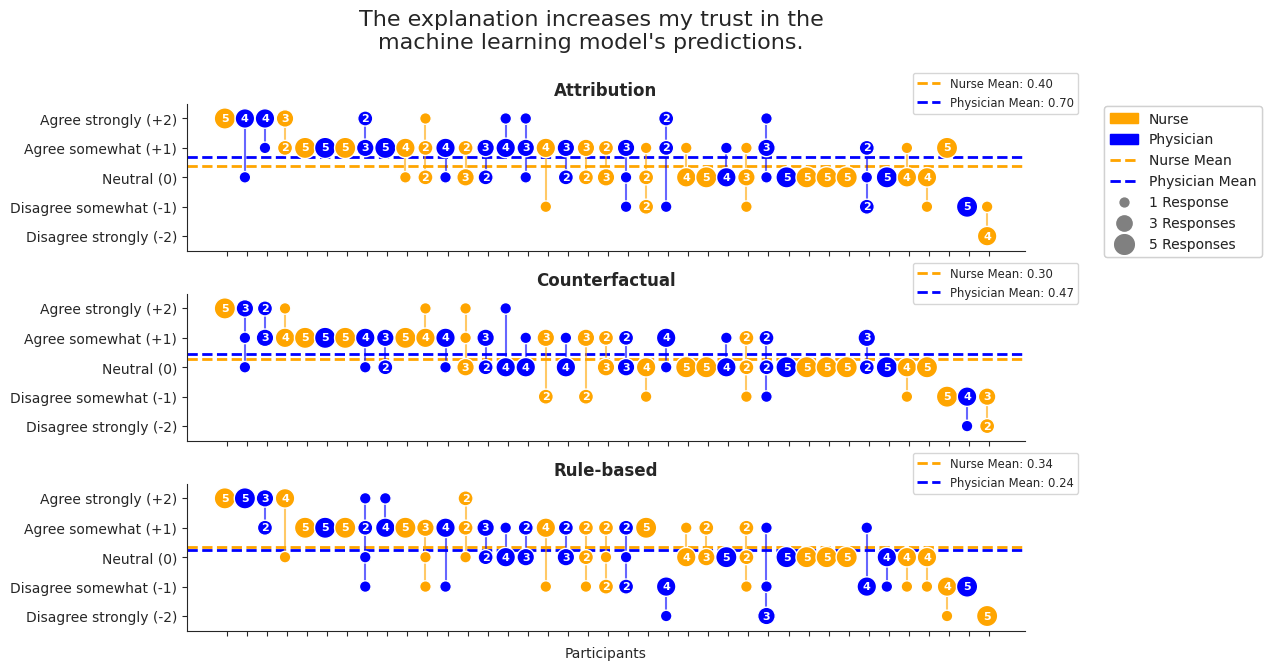

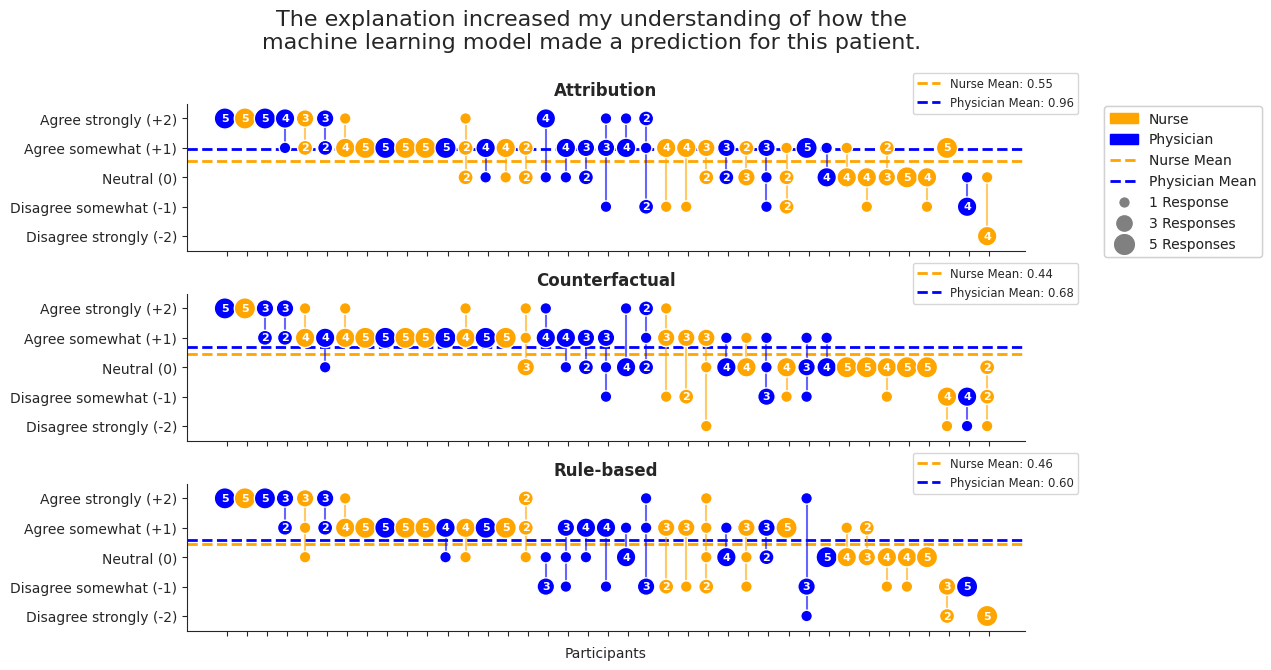

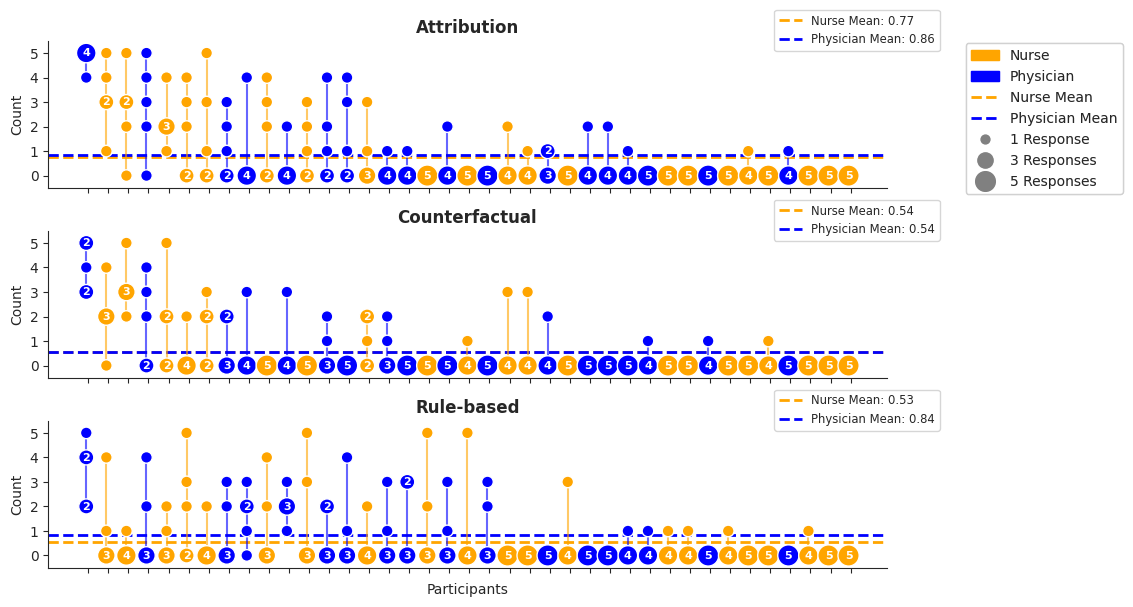

In [128]:
vblocks = [
  ('understand_exp',
  "I understand the explanation of the machine learning\nmodel's prediction for this patient case.",
  [x for x in range(-2, 3)],
  agreelist[::-1], #ral
  (-2.5,2.5),
  2,
  4.6,
  ""),

  ('increase_trust_ml_model',
  "The explanation increases my trust in the\nmachine learning model's predictions.",
  [x for x in range(-2, 3)],
  agreelist[::-1], #ral
  (-2.5,2.5),
  2,
  4.6,
  ""),

  ('increase_understand_ml_model',
  "The explanation increased my understanding of how the\nmachine learning model made a prediction for this patient.",
  [x for x in range(-2, 3)],
  agreelist[::-1],
  (-2.5,2.5),
  2,
  4.6,
  ""),

  ('any_dif_from_prev',
  "",
  [x for x in range(0,6)],
  [x for x in range(0,6)],
  (-0.5, 5.5),
  2,
  4.6,
  "Count"),

  # ('shifted_from_prev_dist_wm',
  # "Distance of Ranking Changes",
  # [x for x in range(0,19)],
  # [x for x in range(0,19)],
  # None,
  # 3,
  # 3)
]

for value_column, titletext, yt, ytl, ylim2, ho, ao, ylbltxt in vblocks:

  temp_data = per_question_data[per_question_data['exp_type'] != 'initial']

  custom_order = ['Attribution', 'Counterfactual', 'Rule-based']
  temp_data['exp_type'] = pd.Categorical(temp_data['exp_type'], categories=custom_order, ordered=True)
  temp_data = temp_data.sort_values(by='exp_type')

  record_means = temp_data.groupby('record_id')[value_column].mean()
  ordered_ids = record_means.sort_values(ascending=True).index.tolist()

  for i, oid in enumerate(ordered_ids):
    # print(f"ordered_ids: {oid}")

    temp_data[temp_data['record_id'] == oid]['record_id'] = -1*i
  temp_data['record_id'] = temp_data['record_id'] * -1
  temp_data = temp_data.sort_values('record_id')

  temp_data


  create_dotstrip_plot(
      col_recid='record_id',
      col_val=value_column,
      col_exptype='exp_type',
      df=temp_data,
      divide_by_explanation_type=True,
      title=titletext,
      xlabel="Participants",
      ylabel=ylbltxt,
      ylim=ylim2,
      xticks=[x for x in range(39)],
      xticklabels=["" for x in range(39)],
      yticks=yt,
      yticklabels=ytl,
      heightoverride=ho,
      aspectoverride=ao,
      show_mean_val=True
  )

In [151]:


def create_arrow_plot(
    df: pd.DataFrame,
    postval = None,
    preval = None,
    color_on_col: str = None,
    palette: dict = None,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    ylim: tuple = None,
    xticks: list = None,
    xticklabels: list = None,
    yticks: list = None,
    yticklabels: list = None,
):
    """
    Generates a scatter plot with arrows, with elements colored by a specified column.
    """
    # --- Style Setup ---
    sns.set_style("ticks")
    # sns.set_context("paper", font_scale=1.4)
    # ... (other style settings) ...

    # --- Data and Color Preparation ---
    plot_df = df.drop_duplicates(subset=['record_id'])#.sort_values('record_id').reset_index()
    # x_positions = plot_df.index

    class HandlerFancyArrow(HandlerPatch):
      def create_artists(self, legend, orig_handle,
                        xdescent, ydescent, width, height, fontsize, trans):
          # Create a simplified arrow for the legend
          # You can adjust the arrow properties as needed for the legend representation
          p = patches.FancyArrow(xdescent, ydescent + height / 2,
                                width, 0, width=0.01 * width,
                                head_width=0.5 * height, head_length=0.5 * width,
                                facecolor=orig_handle.get_facecolor(),
                                edgecolor=orig_handle.get_edgecolor(),
                                transform=trans)
          return [p]

    # --- Create Figure and Axes ---
    fig, ax = plt.subplots(figsize=(12, 2.5))

    # --- Plotting Loop ---
    y_range = plot_df[postval].max() - plot_df[preval].min()
    head_length = 0.04 * y_range if y_range > 0 else 0.1

    nurse_legend = []
    physician_legend = []
    legend_text = []
    for i, row in plot_df.iterrows():
        pre_val, post_val = row[preval], row[postval]
        # print(f"i: {i}, pre_val:{pre_val}, post_val:{post_val}")

        # Determine the color for the current record
        color = palette[row[color_on_col]] if color_on_col else 'black'

        # Draw the arrow with the specified color
        deltaval = (post_val - pre_val)
        if deltaval < 0:
          deltaval += 0.15
        elif deltaval > 0:
          deltaval -= 0.15
        arr = ax.arrow(
            x=i, y=pre_val, dx=0, dy=deltaval,
            color=color,
            alpha=0.5, head_width=0.75, head_length=0.25,
            width=0.2, length_includes_head=True
        )

        # Draw the dots with the specified color
        start = ax.scatter(i, pre_val,
                   edgecolor=color,  # Set the color of the circle's edge
                   facecolor='none',
                   s=80, zorder=3, marker='X') # Pre-value
        end = ax.scatter(i, post_val,
                   edgecolor=color,  # Set the color of the circle's edge
                   facecolor='none',
                   s=80, zorder=3, marker='o') # Post-value

        arrow_handle = mpatches.FancyArrowPatch((0, 0), (1, 1), color='gray', mutation_scale=15, label='Change in Value')

        # if row[color_on_col] == 'Nurse' and len(nurse_legend) == 0:
        #     nurse_legend += [start, end]
        # if row[color_on_col] == 'Physician' and len(physician_legend) == 0:
        #     # physician_legend += [start, end]
        #     # legend_text += [f"{row[color_on_col]} Change in Importance", f"{row[color_on_col]} Pre-Cases Importance", f"{row[color_on_col]} Post-Cases Importance"]


    # legend_handles = nurse_legend + physician_legend

    class ArrowHandler(HandlerPatch):
      def create_artists(self, legend, orig_handle,
                        xdescent, ydescent, width, height, fontsize, trans):

          # Create the arrow artist for the legend
          p = mpatches.FancyArrowPatch(
              posA=(0, height / 2),
              posB=(width, height / 2),
              # This is the corrected part:
              # Safely get the arrow style from the original handle
              mutation_scale=orig_handle.get_mutation_scale(),
              arrowstyle=orig_handle.get_arrowstyle()
          )

          # Copy the visual properties (like color) from the original handle
          self.update_prop(p, orig_handle, legend)
          p.set_transform(trans)
          return [p]

    arrow_handle = mpatches.FancyArrowPatch((0, 0), (1, 1), color='gray', mutation_scale=15)
    physician_handle = mpatches.Patch(color='blue', label='Physician')
    nurse_handle = mpatches.Patch(color='orange', label='Nurse')
    empty_circle_handle = Line2D(
      [0], [0],                # Placeholder data points
      marker='o',              # Specifies the circle shape
      linestyle='None',        # Hides the line
      markersize=10,
      markerfacecolor='none',  # Makes the circle empty
      markeredgecolor='gray',  # Sets the color of the outline
      label='Empty Circle'     # The text that will appear in the legend
    )
    diamond_handle = Line2D(
      [0], [0],              # Placeholder data points
      marker='X',            # Specifies the diamond shape
      linestyle='None',      # Hides the line
      markersize=8,          # Adjusted size for diamond shape
      markerfacecolor='none',  # Makes the circle empty
      markeredgecolor='gray',  # Sets the color of the outline
      label='X Icon'   # The text that will appear in the legend
    )

    legend_handles = [nurse_handle, physician_handle, diamond_handle, empty_circle_handle, (diamond_handle, empty_circle_handle), arrow_handle]
    ax.legend(
        title="",
        handles=legend_handles, #x is pre-val
        labels=["Nurse", "Physician","Pre-Cases Importance","Post-Cases Importance","No Change in Pre- to Post-Cases Importance", "Change in Importance"],
        loc='upper left',
        bbox_to_anchor=(1.02, 1),
        handler_map={mpatches.FancyArrowPatch: ArrowHandler()}
        )

    # --- Customization & Final Touches ---
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=45, ha='right')
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    sns.despine()
    fig.tight_layout()
    # plt.legend(handler_map={patches.FancyArrow: HandlerFancyArrow()})

    return fig, ax

In [152]:
[x for x in list(raw_data.columns) if 'import' in x]

['initial_r_expimportance',
 'post_importance',
 'init_importance',
 'post_importance2',
 'pre_vs_post_importance']

In [153]:
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as patches

# Custom handler for FancyArrow




(<Figure size 1200x250 with 1 Axes>,
 <Axes: title={'center': "Clinicians' Change in Pre-Cases vs. Post-Cases Importance"}, xlabel='Participants'>)

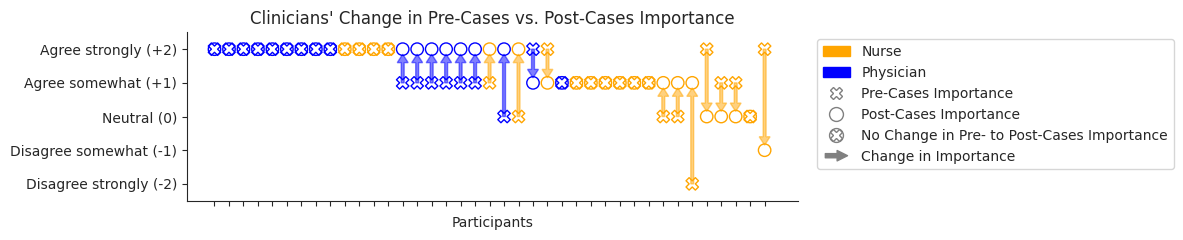

In [154]:

# temp_data = copy.deepcopy(raw_data)
temp_data = raw_data.sort_values(by=["post_importance", "initial_r_expimportance", "is_nurse_or_not"], ascending=False).reset_index()
temp_data[["initial_r_expimportance", "post_importance", "is_nurse_or_not"]]

create_arrow_plot(
    df=temp_data,
    preval="initial_r_expimportance",
    postval="post_importance",
    color_on_col='is_nurse_or_not',
    palette=HUE_COLORS,
    title="Clinicians' Change in Pre-Cases vs. Post-Cases Importance",
    xlabel="Participants",
    ylabel="",
    ylim=(-2.5,2.5),
    xticks=[x for x in range(39)],
    xticklabels=["" for x in range(39)],
    yticks=[x for x in range(-2, 3)],
    yticklabels=agreelist[::-1],
)

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import copy

def create_chain_plot(
    df: pd.DataFrame,
    field_1: str,
    field_2: str,
    field_3: str,
    show_bar_comparison: bool = False, # <-- New Argument
    color_on_col: str = None,
    palette: dict = None,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    ylim: tuple = None,
    xticks: list = None,
    xticklabels: list = None,
    yticks: list = None,
    yticklabels: list = None,
    x_label_map: dict = None
):
    """
    Generates a chain plot and an optional, side-by-side bar plot comparing
    the mean values for each explanation type.
    """
    # --- Style Setup ---
    sns.set_style("ticks")

    df=copy.deepcopy(df)
    df['mean_value_field'] = df[[field_1, field_2, field_3]].mean(axis=1)
    df = df.sort_values(by='mean_value_field', ascending=False)
    df = df.drop(columns=['mean_value_field'])

    plot_df = df.drop_duplicates(subset=['record_id']).reset_index(drop=True)

    # --- Create Figure and Axes ---
    if show_bar_comparison:
        # Create a figure with two subplots: one for the chain plot, one for the bar plot
        fig, (ax, ax_bar, ax_bar2) = plt.subplots(
            nrows=1, ncols=3, figsize=(18, 4),
            gridspec_kw={'width_ratios': [5, 2, 2]} # Make chain plot wider
        )
        ax.tick_params(axis='y', labelleft=True)
        ax_bar.tick_params(axis='y', labelleft=True)
        ax_bar2.tick_params(axis='y', labelleft=False)

        # fig.subplots_adjust(left=0.3, right=0.95, hspace=0.1, wspace=0.2)
        ax_bar2.set_position([ax_bar.get_position().x1, ax_bar2.get_position().y0,
        ax_bar2.get_position().width, ax_bar2.get_position().height])
    else:
        # Original figure creation for a single plot
        fig, ax = plt.subplots(figsize=(12, 2.5))

    # --- Plotting Loop (for the main chain plot on 'ax') ---
    for i, row in plot_df.iterrows():
        val1, val2, val3 = row[field_1], row[field_2], row[field_3]
        y_values = [val1, val2, val3]
        color = palette.get(row[color_on_col], 'black') if color_on_col else 'black'

        ax.plot([i, i, i], y_values, color=color, alpha=0.4, zorder=1)
        ax.scatter(i, val1, color=color, s=80, zorder=3, marker='x')
        ax.scatter(i, val2, color=color, s=140, zorder=3, marker='+')
        ax.scatter(i, val3, edgecolor=color, facecolor='none', s=110, zorder=3, marker='s')

    # --- Main Legend ---
    main_legend_lbls = ['Nurse', 'Physician', 'Attribution', 'Counterfactual', 'Rule-based']
    color_handles = [mpatches.Patch(color=color, label=name) for name, color in palette.items()] if palette else []
    marker_handles = [
        Line2D([0], [0], marker='x', color='gray', linestyle='None', markersize=9, label=field_1),
        Line2D([0], [0], marker='+', color='gray', linestyle='None', markersize=9, label=field_2),
        Line2D([0], [0], marker='s', markerfacecolor='none', markeredgecolor='gray', linestyle='None', markersize=9, label=field_3)
    ]
    ax.legend(handles=color_handles + marker_handles, labels=main_legend_lbls, loc='upper left', bbox_to_anchor=(0.85, 1.35))

    # --- Customization for the main plot ---
    ax.set_title(title, y=1.1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels if xticklabels is not None else xticks, rotation=45, ha='right')
    else:
        ax.set_xticks(plot_df.index)
        ax.set_xticklabels(plot_df['record_id'], rotation=45, ha='right')
    if yticks: ax.set_yticks(yticks)
    if yticklabels: ax.set_yticklabels(yticklabels)
    if ylim: ax.set_ylim(ylim)

    # --- Conditionally Add Bar Comparison Plot ---
    if show_bar_comparison:

        for k, vu in enumerate(df[color_on_col].unique()):
          if vu == 'Nurse':
            plotbar = ax_bar
            pal = 'YlOrBr'
            ax_bar.set_yticks(yticks)
            ax_bar.set_yticklabels(["-2", "-1", "0", "+1", "+2"])
          else:
            plotbar = ax_bar2
            pal = 'Blues'
            pltyticklbls = []
            pltyticks = []
            # ax_bar2.set_yticks([])
            # ax_bar2.set_yticklabels([])
          bardf = df[df[color_on_col] == vu]

          # 1. Calculate the mean of each specified field
          bar_data = bardf[[field_1, field_2, field_3]].mean()

          # Define the baseline for the bars
          baseline = -2

          # 2. Draw the bar plot using ax.bar to set a custom baseline
          bars = plotbar.bar(
              x=bar_data.index,
              height=bar_data.values - baseline, # Height is the value minus the baseline
              bottom=baseline,                   # Set the starting point for the bars
              color=sns.color_palette(pal, n_colors=len(bar_data))
          )

          # --- Apply your 4 customizations ---

          # Part 1: Display mean value above each bar
          for bar in bars:
              yval = bar.get_height() + baseline # Get the actual data value
              plotbar.text(
                  bar.get_x() + bar.get_width()/2.0,
                  yval + 0.05, # Position text slightly above the bar
                  f'{yval:.2f}', # Format to 2 decimal places
                  ha='center', va='bottom', fontsize='small'
              )

          # Part 2: Keep Y-axis line but remove tick values
          sns.despine(ax=plotbar, left=False) # 'left=False' keeps the y-axis line visible

          # Part 3: Synchronize the y-axis scales (baseline is handled above)
          main_ylim = ax.get_ylim()
          plotbar.set_ylim(main_ylim)

          # Part 4: Map the x-axis labels using the provided dictionary
          if x_label_map:
              original_labels = bar_data.index
              new_labels = [[v for k,v in x_label_map.items() if k in label][0] for label in original_labels]
              plotbar.set_xticklabels(new_labels)

          # --- General bar plot styling ---
          plotbar.set_title(f"{vu} Means", fontsize='medium')
          plotbar.set_xlabel(None)
          plotbar.set_ylabel(None)
          plotbar.tick_params(axis='x', labelsize='small')

    sns.despine(ax=ax)
    fig.tight_layout()

    # Return the correct set of axes
    if show_bar_comparison:
        return fig, (ax, ax_bar, ax_bar2)
    else:
        return fig, ax

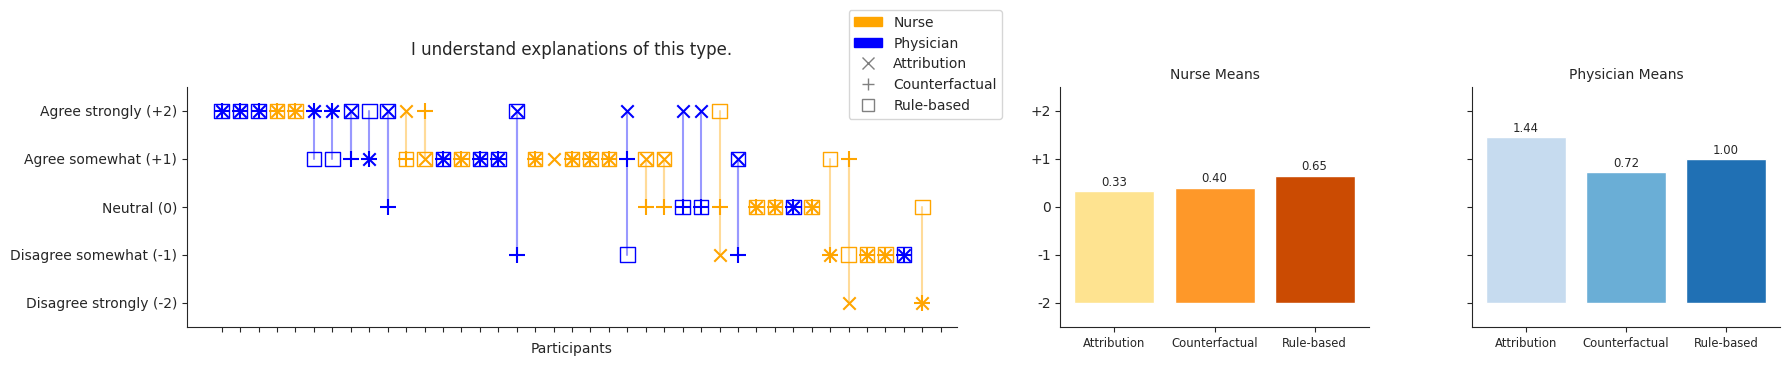

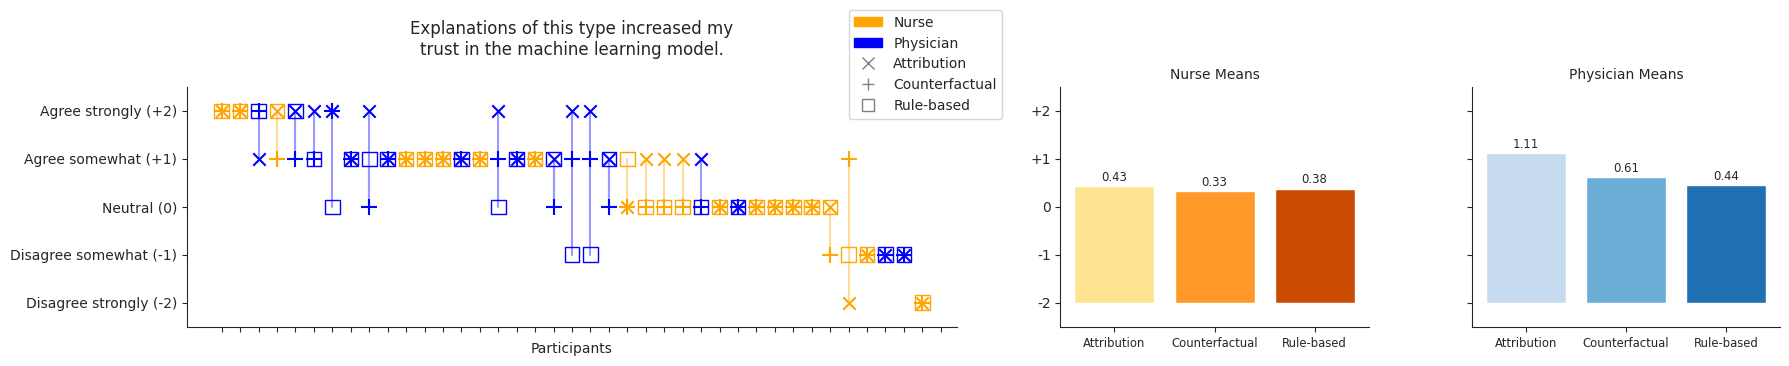

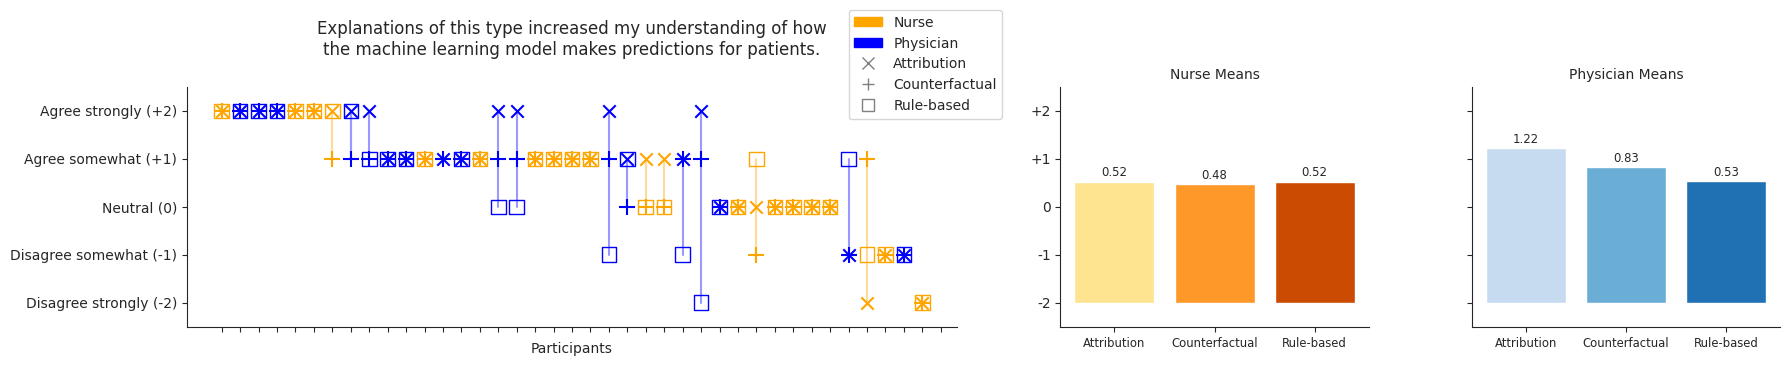

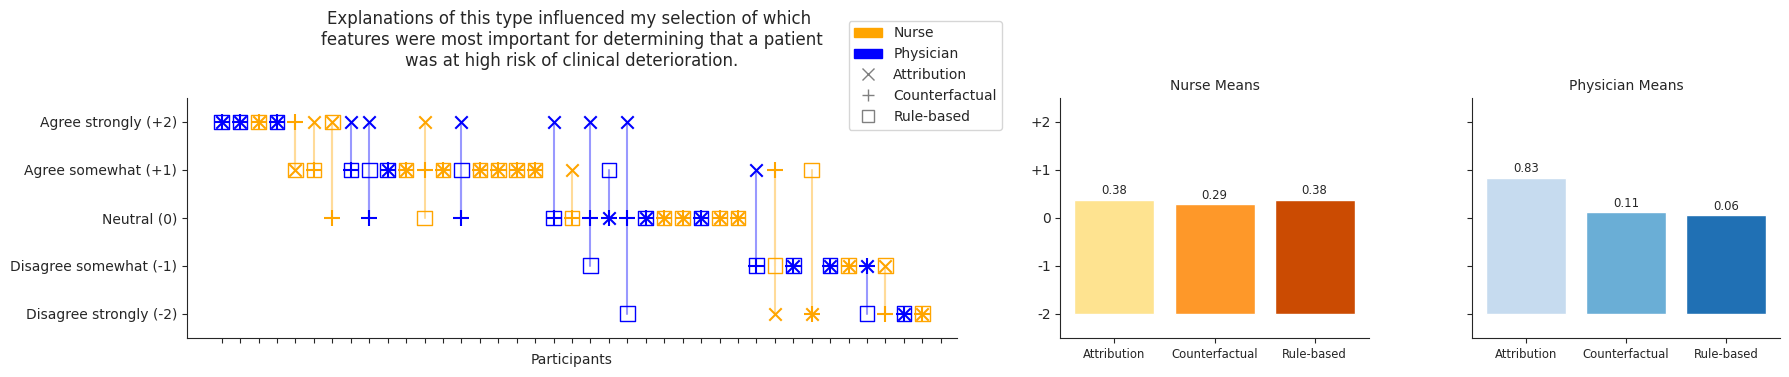

In [64]:
hc = {k:v for k,v in HUE_COLORS.items() if k=='Nurse' or k=='Physician'}

vblock = [
  (['post_at_understand', 'post_cf_understand', 'post_rb_understand', ], #post_expunderstand_1
  "I understand explanations of this type."),

  (['post_at_changetrust', 'post_cf_changetrust', 'post_rb_changetrust', ], #post_modeltrust_1
  "Explanations of this type increased my\ntrust in the machine learning model."),

  (['post_at_increaseunderstand', 'post_cf_increaseunderstand', 'post_rb_increaseunderstand', ], #post_modelunderstand_1
  "Explanations of this type increased my understanding of how\nthe machine learning model makes predictions for patients."),

  (['post_at_influenceme', 'post_cf_influenceme', 'post_rb_influenceme', ], #post_influence_1
  "Explanations of this type influenced my selection of which \nfeatures were most important for determining that a patient\nwas at high risk of clinical deterioration.")
]

for vnames, v_title in vblock:

  create_chain_plot(
      df=raw_data,
      field_1=vnames[0],
      field_2=vnames[1],
      field_3=vnames[2],
      color_on_col='is_nurse_or_not',
      palette=hc,
      title=v_title,
      xlabel = "Participants",
      ylabel = None,
      ylim = (-2.5, 2.5),
      xticks = list(range(0,40)),
      xticklabels = ["" for x in range(40)],
      yticks = list(range(-2,3)),
      yticklabels = agreelist[::-1],
      show_bar_comparison=True,
      x_label_map = {'_at_':'Attribution', '_cf_':'Counterfactual', '_rb_':'Rule-based',}
  )

# Statistical Tests of Results

In [65]:
[x for x in raw_data.columns if 'trust' in x]

['initial_r_mltrust',
 'increasetrust_first_q1',
 'increasetrust_second_q1',
 'increasetrust_third_q1',
 'increasetrust_first_q2',
 'increasetrust_second_q2',
 'increasetrust_third_q2',
 'increasetrust_first_q3',
 'increasetrust_second_q3',
 'increasetrust_third_q3',
 'increasetrust_first_q4',
 'increasetrust_second_q4',
 'increasetrust_third_q4',
 'increasetrust_first_q5',
 'increasetrust_second_q5',
 'increasetrust_third_q5',
 'post_at_changetrust',
 'post_cf_changetrust',
 'post_rb_changetrust']

In [66]:
from scipy.stats import wilcoxon
# from statsmodels.stats.descriptivestats import sign_test
from scipy.stats import binomtest

for xc in [
    ('init_importance', 'post_importance2', 'Nurse'),
    ('init_importance', 'post_importance2', 'Physician'),
    ('init_importance', 'post_importance2', None),
]:

  if xc[2] != None:
    datacol = (raw_data[raw_data['is_nurse_or_not'] == xc[2]][[xc[0]] + [xc[1]]]).dropna().astype(int)
  else:
    datacol = (raw_data[[xc[0]] + [xc[1]]]).dropna().astype(int)
  # print(datacol)
  differences = datacol[xc[1]] - datacol[xc[0]]

  positive_differences = np.sum(differences > 0)
  negative_differences = np.sum(differences < 0)
  n_total = positive_differences+negative_differences

  # print(f"increases: {positive_differences}, decreases: {negative_differences}, inc+dec: {n_total}")

  res = binomtest(k=positive_differences, n=n_total, p=0.5, alternative='greater') #alternative='two-sided'
  # stat, p_value = sign_test(datacol, mu0=0)

  wilcoxonstat, wilcoxonp_value = wilcoxon(datacol[xc[1]], datacol[xc[0]], alternative='greater')

  print(f"======================= {xc} ================================")
  print(f"Sign Test Statistic: {res.statistic:.4f}")
  print(f"Sign Test P-value: {res.pvalue}")
  print(f"Wilcoxon Statistic: {wilcoxonstat.item():.4f}")
  print(f"Wilcoxon P-value: {wilcoxonp_value}")
  # print(f"datacol: {datacol.value_counts()}")
  print(f"Mean: {differences.mean()}")
  print(f"Std: {differences.std()}")
  print("-----------------------------------------------------------------")

======================= ('init_importance', 'post_importance2', 'Nurse') ================================
Sign Test Statistic: 0.5000
Sign Test P-value: 0.623046875
Wilcoxon Statistic: 27.5000
Wilcoxon P-value: 0.5
Mean: 0.0
Std: 1.2649110640673518
-----------------------------------------------------------------
======================= ('init_importance', 'post_importance2', 'Physician') ================================
Sign Test Statistic: 0.8750
Sign Test P-value: 0.03515625
Wilcoxon Statistic: 32.0000
Wilcoxon P-value: 0.017404239405933563
Mean: 0.3888888888888889
Std: 0.6978023391872252
-----------------------------------------------------------------
======================= ('init_importance', 'post_importance2', None) ================================
Sign Test Statistic: 0.6667
Sign Test P-value: 0.1189422607421875
Wilcoxon Statistic: 110.5000
Wilcoxon P-value: 0.1271944443500982
Mean: 0.1794871794871795
Std: 1.048100910966187
----------------------------------------------------

In [67]:
from scipy.stats import wilcoxon
from statsmodels.stats.descriptivestats import sign_test

for xc in ['understand_exp', 'increase_trust_ml_model', 'increase_understand_ml_model', 'any_dif_from_prev']:
  datacol = (per_question_data[xc]).dropna()
  wilcoxonstat, wilcoxonp_value = wilcoxon(datacol, alternative='greater')
  stat, p_value = sign_test(datacol, mu0=0)

  print(f"======================= {xc} ================================")
  print(f"Sign Test Statistic: {stat:.4f}")
  print(f"Sign Test P-value: {p_value}")
  print(f"Wilcoxon Statistic: {wilcoxonstat:.4f}")
  print(f"Wilcoxon P-value: {wilcoxonp_value}")
  # print(f"datacol: {datacol.value_counts()}")
  print(f"Mean: {per_question_data[xc].mean()}")
  print(f"Std: {per_question_data[xc].std()}")
  print("-----------------------------------------------------------------")



for xc in ['initial_r_mltrust']:
  datacol = (raw_data[xc]).dropna()
  wilcoxonstat, wilcoxonp_value = wilcoxon(datacol, alternative='greater')
  stat, p_value = sign_test(datacol, mu0=0)

  print(f"======================= {xc} ================================")
  print(f"Sign Test Statistic: {stat:.4f}")
  print(f"Sign Test P-value: {p_value}")
  print(f"Wilcoxon Statistic: {wilcoxonstat:.4f}")
  print(f"Wilcoxon P-value: {wilcoxonp_value}")
  # print(f"datacol: {datacol.value_counts()}")
  print(f"Mean: {raw_data[xc].mean()}")
  print(f"Std: {raw_data[xc].std()}")
  print("-----------------------------------------------------------------")

======================= understand_exp ================================
Sign Test Statistic: 164.5000
Sign Test P-value: 1.0963500927359032e-56
Wilcoxon Statistic: 95353.5000
Wilcoxon P-value: 7.222489012269213e-46
Mean: 0.7363013698630136
Std: 0.974274952262105
-----------------------------------------------------------------
======================= increase_trust_ml_model ================================
Sign Test Statistic: 97.0000
Sign Test P-value: 1.5826375039220545e-25
Wilcoxon Statistic: 50092.5000
Wilcoxon P-value: 8.549838132400963e-22
Mean: 0.40341880341880343
Std: 0.918598883195201
-----------------------------------------------------------------
======================= increase_understand_ml_model ================================
Sign Test Statistic: 138.5000
Sign Test P-value: 1.6422657640951226e-43
Wilcoxon Statistic: 77097.0000
Wilcoxon P-value: 2.9600936032423885e-36
Mean: 0.6030927835051546
Std: 0.961670263310192
-------------------------------------------------------

In [68]:

triples = [
    ('post_at_understand', 'post_cf_understand', 'post_rb_understand'),
    ('post_at_changetrust', 'post_cf_changetrust', 'post_rb_changetrust'),
    ('post_at_increaseunderstand', 'post_cf_increaseunderstand', 'post_rb_increaseunderstand'),
    ('post_at_influenceme', 'post_cf_influenceme', 'post_rb_influenceme'),
    # ('post_at_understand', 'post_cf_understand', 'post_rb_understand'),
]

for field1, field2, field3 in triples:
  for splittype in ['Nurse', 'Physician', None]:
    tempdata = raw_data
    if splittype is not None:
        tempdata = raw_data[raw_data['is_nurse_or_not'] == splittype]
    stackeddata = pd.concat([tempdata[field1], tempdata[field2], tempdata[field3]], axis=0).dropna()
    mean1 = stackeddata.mean()
    stdev1 = stackeddata.std()

    wilcoxonstat, wilcoxonp_value = wilcoxon(stackeddata, alternative='greater')
    stat, p_value = sign_test(stackeddata, mu0=0)

    print(f"======================= {field1} + {field2} + {field3} - {splittype} ================================")
    print(f"Mean with std:    {mean1} \\pm {stdev1}")
    print(f"Sign Test Statistic: {stat:.4f}")
    print(f"Sign Test P-value: {p_value}")
    print(f"Wilcoxon Statistic: {wilcoxonstat:.4f}")
    print(f"Wilcoxon P-value: {wilcoxonp_value}")
    print("-----------------------------------------------------------------")

======================= post_at_understand + post_cf_understand + post_rb_understand - Nurse ================================
Mean with std:    0.45901639344262296 \pm 1.0889409303202702
Sign Test Statistic: 11.0000
Sign Test P-value: 0.0020881073339964478
Wilcoxon Statistic: 863.5000
Wilcoxon P-value: 0.0014022440920342342
-----------------------------------------------------------------
======================= post_at_understand + post_cf_understand + post_rb_understand - Physician ================================
Mean with std:    1.0555555555555556 \pm 1.0171485609135733
Sign Test Statistic: 17.0000
Sign Test P-value: 3.1028037028590916e-07
Wilcoxon Statistic: 1009.0000
Wilcoxon P-value: 6.442060695361292e-08
-----------------------------------------------------------------
======================= post_at_understand + post_cf_understand + post_rb_understand - None ================================
Mean with std:    0.7391304347826086 \pm 1.0929355009117954
Sign Test Statistic: 28.00

In [69]:
from scipy.stats import wilcoxon
from statsmodels.stats.descriptivestats import sign_test

for xc in ['understand_exp', 'increase_trust_ml_model', 'increase_understand_ml_model', 'any_dif_from_prev']:
  for expt in ['Attribution', 'Counterfactual', 'Rule-based']:

    tmp_data = per_question_data[per_question_data['exp_type'] == expt]
    datacol = (tmp_data[xc]).dropna()
    wilcoxonstat, wilcoxonp_value = wilcoxon(datacol, alternative='greater')
    stat, p_value = sign_test(datacol, mu0=0)

    print(f"======================= {xc} {expt} ================================")
    print(f"Sign Test Statistic: {stat:.4f}")
    print(f"Sign Test P-value: {p_value}")
    print(f"Wilcoxon Statistic: {wilcoxonstat:.4f}")
    print(f"Wilcoxon P-value: {wilcoxonp_value}")
    # print(f"datacol: {datacol.value_counts()}")
    print(f"Mean: {datacol.mean()}")
    print(f"Std: {datacol.std()}")
    print("-----------------------------------------------------------------")





======================= understand_exp Attribution ================================
Sign Test Statistic: 66.0000
Sign Test P-value: 2.0707568742771897e-28
Wilcoxon Statistic: 12082.5000
Wilcoxon P-value: 2.6195662538902936e-22
Mean: 0.882051282051282
Std: 0.8742807927508702
-----------------------------------------------------------------
======================= understand_exp Counterfactual ================================
Sign Test Statistic: 52.0000
Sign Test P-value: 6.485282938356565e-19
Wilcoxon Statistic: 9413.0000
Wilcoxon P-value: 1.2149244378725118e-15
Mean: 0.6666666666666666
Std: 0.9342656119524984
-----------------------------------------------------------------
======================= understand_exp Rule-based ================================
Sign Test Statistic: 46.5000
Sign Test P-value: 7.914760031941316e-14
Wilcoxon Statistic: 10510.0000
Wilcoxon P-value: 9.162936501888313e-13
Mean: 0.6597938144329897
Std: 1.0905776188605132
-------------------------------------------

In [70]:
per_question_data[['understand_exp', 'exp_type']].groupby('exp_type').std()
# per_question_data['understand_exp'].std()

,understand_exp
exp_type,
Attribution,0.874281
Counterfactual,0.934266
Rule-based,1.090578
initial,NaN


In [71]:
per_question_data[['increase_trust_ml_model', 'exp_type']].groupby('exp_type').std()
# [x for x in list(per_question_data.columns) if 'trust' in x]
# per_question_data['increase_trust_ml_model'].mean()

,increase_trust_ml_model
exp_type,
Attribution,0.880667
Counterfactual,0.823845
Rule-based,1.027329
initial,NaN


In [72]:
per_question_data[['increase_understand_ml_model', 'exp_type']].groupby('exp_type').std()
# [x for x in list(per_question_data.columns) if 'under' in x]
# per_question_data['increase_understand_ml_model'].std()

,increase_understand_ml_model
exp_type,
Attribution,0.909344
Counterfactual,0.914621
Rule-based,1.046186
initial,NaN


In [73]:
[x for x in list(raw_data.columns) if 'post_at' in x]


for v in ['post_at_understand', 'post_cf_understand', 'post_rb_understand',
          'post_at_changetrust', 'post_cf_changetrust', 'post_rb_changetrust',
          'post_at_increaseunderstand', 'post_cf_increaseunderstand', 'post_rb_increaseunderstand',
          'post_at_influenceme', 'post_cf_influenceme', 'post_rb_influenceme']:

    datacol = (raw_data[v]).dropna()
    wilcoxonstat, wilcoxonp_value = wilcoxon(datacol, alternative='greater')
    stat, p_value = sign_test(datacol, mu0=0)

    print(f"======================= {v} ================================")
    print(f"Sign Test Statistic: {stat:.4f}")
    print(f"Sign Test P-value: {p_value}")
    print(f"Wilcoxon Statistic: {wilcoxonstat:.4f}")
    print(f"Wilcoxon P-value: {wilcoxonp_value}")
    # print(f"datacol: {datacol.value_counts()}")
    print(f"Mean: {datacol.mean()}")
    print(f"Std: {datacol.std()}")
    print("-----------------------------------------------------------------")

======================= post_at_understand ================================
Sign Test Statistic: 10.5000
Sign Test P-value: 0.0005082604475319386
Wilcoxon Statistic: 525.0000
Wilcoxon P-value: 0.0001928733778410033
Mean: 0.8461538461538461
Std: 1.2039072690828838
-----------------------------------------------------------------
======================= post_cf_understand ================================
Sign Test Statistic: 7.0000
Sign Test P-value: 0.012540951371192932
Wilcoxon Statistic: 322.0000
Wilcoxon P-value: 0.002343978650966821
Mean: 0.5526315789473685
Std: 1.0829730954471142
-----------------------------------------------------------------
======================= post_rb_understand ================================
Sign Test Statistic: 10.5000
Sign Test P-value: 0.00019219517707824707
Wilcoxon Statistic: 441.0000
Wilcoxon P-value: 3.9550644687641446e-05
Mean: 0.8157894736842105
Std: 0.9824201544584691
-----------------------------------------------------------------
===========

In [74]:
v1 = pd.concat([raw_data['post_at_understand'], raw_data['post_cf_understand'], raw_data['post_rb_understand']], axis=0)
print(f"{v1.mean():.3f} \\pm {v1.std():.3f}")

0.739 \pm 1.093


In [75]:
v1 = pd.concat([raw_data['post_at_changetrust'], raw_data['post_cf_changetrust'], raw_data['post_rb_changetrust']], axis=0)
print(f"{v1.mean():.3f} \\pm {v1.std():.3f}")

0.538 \pm 1.005


In [76]:
v1 = pd.concat([raw_data['post_at_increaseunderstand'], raw_data['post_cf_increaseunderstand'], raw_data['post_rb_increaseunderstand']], axis=0)
print(f"{v1.mean():.3f} \\pm {v1.std():.3f}")

0.672 \pm 1.078


In [77]:
v1 = pd.concat([raw_data['post_at_influenceme'], raw_data['post_cf_influenceme'], raw_data['post_rb_influenceme']], axis=0)
print(f"{v1.mean():.3f} \\pm {v1.std():.3f}")

0.342 \pm 1.240


In [78]:
[x for x in list(raw_data.columns) if 'initial' in x]

raw_data['initial_r_mltrust'].std()

0.8230813374079162

In [79]:
# # @title
# # @title

# # Fit a mixed effects model

# tempdata_5 = copy.deepcopy(raw_data)
# xdata = []
# for i,r in tempdata_5.iterrows():
#   temprec1 = r[['record_id', 'is_nurse_or_not']].to_dict()
#   temprec1['time'] = 'before'
#   temprec1['measurement'] = r['init_importance']
#   xdata.append(temprec1)

#   temprec2 = r[['record_id', 'is_nurse_or_not']].to_dict()
#   temprec2['time'] = 'after'
#   temprec2['measurement'] = r['post_importance2']
#   xdata.append(temprec2)

# df = pd.DataFrame(xdata)
# df


# model = mixedlm("measurement ~ is_nurse_or_not * time", df, groups=df["record_id"])
# result = model.fit()

# # # Summary of the model
# print(result.summary())

# # # Extracting p-value for the interaction term
# # interaction_p_value = result.pvalues['is_nurse_or_not[T.Physician]:time[T.after]']

# # print("p-value for interaction effect:", interaction_p_value)


from scipy.stats import chisquare
tempdata_5 = copy.deepcopy(raw_data)
# tempdata_5 = tempdata_5[tempdata_5['is_nurse_or_not'] == 'Physician'] #Physician Nurse

pre_post_notnan = tempdata_5[['post_importance2', 'init_importance']].dropna()
print(pre_post_notnan[['post_importance2', 'init_importance']].mean(numeric_only=True))

chi2_statistic, p_value = chisquare(
    f_obs= [pre_post_notnan['post_importance2'][pre_post_notnan['post_importance2'] == x].shape[0] for x in range(0, 3)],
    f_exp= [pre_post_notnan['init_importance'][pre_post_notnan['init_importance'] == x].shape[0] for x in range(0, 3)],)
    # f_exp= pre_post_notnan['init_importance'].value_counts().to_list())
print(f"Chi-squared statistic: {chi2_statistic}")
print(f"P-value: {p_value}")



statistic, p_value = wilcoxon(pre_post_notnan['init_importance'], pre_post_notnan['post_importance2'])
print(f"Wilcoxon statistic: {statistic}, p-value: {p_value}")


print(tempdata_5[tempdata_5['is_nurse_or_not'] == 'Physician']['init_importance'].shape)
print(tempdata_5[tempdata_5['is_nurse_or_not'] == 'Nurse']['init_importance'].shape)
# chi2_statistic2, p_value2 = chisquare(
#     tempdata_5[tempdata_5['is_nurse_or_not'] == 'Physician']['init_importance'],
#     tempdata_5[tempdata_5['is_nurse_or_not'] == 'Nurse']['init_importance']
#   )

# print(f"INIT Chi-squared statistic: {chi2_statistic2}")
# print(f"INIT P-value: {p_value2}")
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(tempdata_5['is_nurse_or_not'], tempdata_5['post_importance2'])
INITchi2, INITp, INITdof, INITxpected = chi2_contingency(contingency_table)
print(f"Chi-Squared Statistic: {INITchi2}, p-value: {INITp}")

# print(contingency_table)

post_importance2    1.410256
init_importance     1.230769
dtype: float64
Chi-squared statistic: 2.670588235294118
P-value: 0.2630807873738174
Wilcoxon statistic: 60.5, p-value: 0.2543888887001964
(18,)
(21,)
Chi-Squared Statistic: 14.735209235209238, p-value: 0.002057499231222133


# Weight of Advice (WOA)

In [80]:
# # explanations_data
# per_question_data

In [81]:
def count_list_diff(list1, list2, order_matters=False):
  diffs = 0
  if order_matters:
    max_size = max(len(list1), len(list2))
    min_size = min(len(list1), len(list2))

    for i in range(min_size):
      if list1[i] != list2[i]:
        diffs += 1
    diffs += max_size - min_size
  else:
    for x in list1:
      if x not in list2:
        diffs += 1
    for x in list2:
      if x not in list1:
        diffs += 1

  return diffs

per_question_data
explanations_data
# (final estimate - initial estimate) / (advice - initial estimate)


def calc_woa(ord_matters):
  WOA_from_initial = []
  WOA_from_previous = []
  updated_records = []

  for recid in per_question_data['record_id'].unique():
    rec_matchings = per_question_data[per_question_data['record_id'] == recid]

    for qn in ['q1', 'q2', 'q3', 'q4', 'q5']:
      qn_rec_matchings = rec_matchings[rec_matchings['question_number'] == qn]

      p_initial_selects = qn_rec_matchings[qn_rec_matchings['question_order'] == 'init']['most_to_least_important']
      # print(f"rid:{recid} \t p_initial_selects: {p_initial_selects}")
      p_initial_selects = p_initial_selects.item()

      ordvals = ['first', 'second', 'third']
      for ord_idx in ordvals:
        submatches = qn_rec_matchings[qn_rec_matchings['question_order'] == ord_idx]

        what_exptype = submatches['exp_type']
        # print(f"what_exptype: {what_exptype}")
        what_exp_says = explanations_data[qn.upper()][what_exptype.item()]
        what_participant_selected = submatches['most_to_least_important'].item()
        previous_most_to_least = submatches['previous_most_to_least'].item()

        # print(f"what_exp_says: {what_exp_says}")
        # print(f"p_initial_selects: {p_initial_selects}")
        # print(f"what_participant_selected: {what_participant_selected}")
        # print(f"previous_most_to_least: {previous_most_to_least}")

        denom1 = count_list_diff(what_exp_says, p_initial_selects, order_matters=ord_matters)
        if denom1 != 0:
          pid_WOA_from_initial = count_list_diff(what_participant_selected, p_initial_selects, order_matters=ord_matters) / denom1
          WOA_from_initial.append(pid_WOA_from_initial)
          submatches['WOA_from_initial'] = pid_WOA_from_initial
        else:
          submatches['WOA_from_initial'] = np.nan

        denom2 = count_list_diff(what_exp_says, previous_most_to_least, order_matters=ord_matters)
        if denom2 != 0:
          pid_WOA_from_previous = count_list_diff(what_participant_selected, previous_most_to_least, order_matters=ord_matters) / denom2
          WOA_from_previous.append(pid_WOA_from_previous)
          submatches['WOA_from_previous'] = pid_WOA_from_previous
        else:
          submatches['WOA_from_previous'] = np.nan

        updated_records.append(submatches.squeeze())

  return WOA_from_initial, WOA_from_previous, updated_records




## Order does not matter - WOA comparing against initial ranking ('WOA_from_initial') and previous ranking ('WOA_from_previous')

In [82]:
init_woa, prev_woa, new_recs = calc_woa(ord_matters=False)

print(f"Initial WOA: mean={np.mean(init_woa)} std={np.std(init_woa)}")

dup_per_question_data = pd.DataFrame(new_recs)

print(f"################################## WOA_from_initial ##################################")
print(f"ORDER DOES NOT MATTER")
target_col = 'WOA_from_initial'
temp_data = dup_per_question_data[~dup_per_question_data[target_col].isna()]
temp_data = temp_data[fixed_effect_cols + random_effect_cols + [target_col]]
lmm_model_5, lmm_result_5, lmm_fixed_formula_5, model_data_5 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=fixed_effect_cols,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_5.summary()

Initial WOA: mean=0.3270977973808162 std=0.6215205897219507
################################## WOA_from_initial ##################################
ORDER DOES NOT MATTER
Formula is: WOA_from_initial ~ question_number + question_order + exp_type + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                 MixedLM      Dependent Variable:      WOA_from_initial
No. Observations:      508          Method:                  REML            
No. Groups:            34           Scale:                   0.2459          
Min. group size:       14           Log-Likelihood:          -409.1910       
Max. group size:       15           Converged:               Yes             
Mean group size:       14.9                                                  
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          1.064    0.191   5.555 0.000  0.688  1.439
question_number[T.q2]             -0.759    0.069 -10.932 0.000 -0.895 -0.623
question_number[T.q3]             -0.658    0.070  -9.426 0.000 -0.795 -0.521
question_number[T.q4]             -0.899    0.069 -12.944 0.000 -1.035 -0.763
question_number[T.q5]             -0.779    0.069 -11.219 0.000 -0.915 -0.643
question_order[T.second]           0.127    0.054   2.363 0.018  0.022  0.233
question_order[T.third]            0.126    0.054   2.318 0.020  0.019  0.232
exp_type[T.Counterfactual]        -0.043    0.054  -0.792 0.428 -0.149  0.063
exp_type[T.Rule-based]            -0.159    0.054  -2.950 0.003 -0.265 -0.053
is_nurse_or_not[T.Physician]      -0.164    0.126  -1.296 0.195 -0.412  0.084
site[T.UW-Madison]                -0.124    0.124  -1.000 0.318 -0.368  0.119
demo_gender[T.Male]                0.104    0.126   0.822 0.411 -0.144  0.352
demo_age_range[T.30-39 years old]  0.017    0.134   0.129 0.898 -0.245  0.280
demo_age_range[T.40-49 years old] -0.077    0.157  -0.491 0.623 -0.384  0.230
demo_age_range[T.50-59 years old] -0.154    0.213  -0.722 0.470 -0.572  0.264
initial_r_expimportance            0.044    0.057   0.773 0.440 -0.067  0.155
initial_r_mltrust                 -0.114    0.060  -1.899 0.058 -0.231  0.004
Group Var                          0.052    0.040                            
=============================================================================

"""

In [83]:
print(f"################################## WOA_from_previous ##################################")
print(f"ORDER DOES NOT MATTER")
target_col = 'WOA_from_previous'
temp_data = dup_per_question_data[~dup_per_question_data[target_col].isna()]
temp_data = temp_data[fixed_effect_cols + random_effect_cols + [target_col]]
lmm_model_5, lmm_result_5, lmm_fixed_formula_5, model_data_5 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=fixed_effect_cols,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_5.summary()

################################## WOA_from_previous ##################################
ORDER DOES NOT MATTER
Formula is: WOA_from_previous ~ question_number + question_order + exp_type + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                 MixedLM     Dependent Variable:     WOA_from_previous
No. Observations:      508         Method:                 REML             
No. Groups:            34          Scale:                  0.0693           
Min. group size:       14          Log-Likelihood:         -103.5791        
Max. group size:       15          Converged:              Yes              
Mean group size:       14.9                                                 
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.548    0.123  4.471 0.000  0.308  0.788
question_number[T.q2]             -0.194    0.037 -5.269 0.000 -0.267 -0.122
question_number[T.q3]             -0.156    0.037 -4.203 0.000 -0.228 -0.083
question_number[T.q4]             -0.301    0.037 -8.150 0.000 -0.373 -0.228
question_number[T.q5]             -0.244    0.037 -6.617 0.000 -0.316 -0.172
question_order[T.second]          -0.130    0.029 -4.551 0.000 -0.186 -0.074
question_order[T.third]           -0.166    0.029 -5.770 0.000 -0.222 -0.110
exp_type[T.Counterfactual]        -0.068    0.029 -2.379 0.017 -0.125 -0.012
exp_type[T.Rule-based]            -0.076    0.029 -2.657 0.008 -0.132 -0.020
is_nurse_or_not[T.Physician]      -0.022    0.083 -0.266 0.790 -0.184  0.140
site[T.UW-Madison]                -0.082    0.081 -1.010 0.312 -0.241  0.077
demo_gender[T.Male]                0.053    0.082  0.646 0.518 -0.108  0.215
demo_age_range[T.30-39 years old] -0.051    0.087 -0.582 0.560 -0.222  0.120
demo_age_range[T.40-49 years old] -0.069    0.102 -0.671 0.502 -0.269  0.132
demo_age_range[T.50-59 years old] -0.044    0.139 -0.318 0.750 -0.317  0.228
initial_r_expimportance            0.006    0.037  0.157 0.875 -0.067  0.078
initial_r_mltrust                 -0.013    0.039 -0.329 0.742 -0.089  0.064
Group Var                          0.025    0.032                           
============================================================================

"""

In [84]:
# pd.DataFrame(prev_woa).value_counts()

## Order matters - WOA comparing against initial ranking ('WOA_from_initial') and previous ranking ('WOA_from_previous')

In [85]:
init_woa, prev_woa, new_recs = calc_woa(ord_matters=True)


print(f"Initial WOA: mean={np.mean(init_woa)} std={np.std(init_woa)}")

dup_per_question_data = pd.DataFrame(new_recs)

print(f"################################## WOA_from_initial ##################################")
print(f"ORDER DOES YES MATTER")
target_col = 'WOA_from_initial'
temp_data = dup_per_question_data[~dup_per_question_data[target_col].isna()]
temp_data = temp_data[fixed_effect_cols + random_effect_cols + [target_col]]
lmm_model_5, lmm_result_5, lmm_fixed_formula_5, model_data_5 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=fixed_effect_cols,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_5.summary()


Initial WOA: mean=0.27708180708180713 std=0.36684001071144484
################################## WOA_from_initial ##################################
ORDER DOES YES MATTER
Formula is: WOA_from_initial ~ question_number + question_order + exp_type + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                  MixedLM     Dependent Variable:     WOA_from_initial
No. Observations:       510         Method:                 REML            
No. Groups:             34          Scale:                  0.0743          
Min. group size:        15          Log-Likelihood:         -129.0327       
Max. group size:        15          Converged:              Yes             
Mean group size:        15.0                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.644    0.173  3.728 0.000  0.306  0.983
question_number[T.q2]             -0.206    0.038 -5.398 0.000 -0.281 -0.131
question_number[T.q3]             -0.191    0.038 -5.011 0.000 -0.266 -0.116
question_number[T.q4]             -0.305    0.038 -7.997 0.000 -0.380 -0.230
question_number[T.q5]             -0.230    0.038 -6.036 0.000 -0.305 -0.156
question_order[T.second]           0.046    0.030  1.548 0.122 -0.012  0.104
question_order[T.third]            0.059    0.030  2.005 0.045  0.001  0.118
exp_type[T.Counterfactual]        -0.000    0.030 -0.002 0.998 -0.058  0.058
exp_type[T.Rule-based]            -0.011    0.030 -0.359 0.720 -0.069  0.048
is_nurse_or_not[T.Physician]      -0.059    0.118 -0.496 0.620 -0.291  0.173
site[T.UW-Madison]                -0.172    0.116 -1.483 0.138 -0.401  0.056
demo_gender[T.Male]               -0.002    0.118 -0.014 0.989 -0.234  0.230
demo_age_range[T.30-39 years old] -0.044    0.126 -0.350 0.726 -0.290  0.202
demo_age_range[T.40-49 years old] -0.042    0.147 -0.283 0.777 -0.329  0.246
demo_age_range[T.50-59 years old] -0.067    0.200 -0.337 0.736 -0.459  0.324
initial_r_expimportance            0.021    0.053  0.388 0.698 -0.083  0.125
initial_r_mltrust                 -0.130    0.056 -2.324 0.020 -0.240 -0.020
Group Var                          0.055    0.064                           
============================================================================

"""

In [86]:
print(f"################################## WOA_from_previous ##################################")
print(f"ORDER DOES YES MATTER")
target_col = 'WOA_from_previous'
temp_data = dup_per_question_data[~dup_per_question_data[target_col].isna()]
temp_data = temp_data[fixed_effect_cols + random_effect_cols + [target_col]]
lmm_model_5, lmm_result_5, lmm_fixed_formula_5, model_data_5 = create_mixed_effects_model(
    df=temp_data,
    fixed_cols=fixed_effect_cols,
    random_cols=random_effect_cols,
    target=target_col)

lmm_result_5.summary()

################################## WOA_from_previous ##################################
ORDER DOES YES MATTER
Formula is: WOA_from_previous ~ question_number + question_order + exp_type + is_nurse_or_not + site + initial_r_expimportance + initial_r_mltrust + demo_gender + demo_age_range
Fitting mixed effects model with random intercept for: record_id


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                 MixedLM     Dependent Variable:     WOA_from_previous
No. Observations:      510         Method:                 REML             
No. Groups:            34          Scale:                  0.0574           
Min. group size:       15          Log-Likelihood:         -62.9110         
Max. group size:       15          Converged:              Yes              
Mean group size:       15.0                                                 
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.531    0.138  3.840 0.000  0.260  0.802
question_number[T.q2]             -0.096    0.034 -2.869 0.004 -0.162 -0.030
question_number[T.q3]             -0.077    0.034 -2.309 0.021 -0.143 -0.012
question_number[T.q4]             -0.154    0.034 -4.594 0.000 -0.220 -0.088
question_number[T.q5]             -0.108    0.034 -3.205 0.001 -0.173 -0.042
question_order[T.second]          -0.105    0.026 -4.036 0.000 -0.156 -0.054
question_order[T.third]           -0.128    0.026 -4.918 0.000 -0.179 -0.077
exp_type[T.Counterfactual]        -0.064    0.026 -2.460 0.014 -0.115 -0.013
exp_type[T.Rule-based]            -0.049    0.026 -1.895 0.058 -0.100  0.002
is_nurse_or_not[T.Physician]      -0.054    0.094 -0.576 0.565 -0.239  0.131
site[T.UW-Madison]                -0.140    0.093 -1.508 0.132 -0.322  0.042
demo_gender[T.Male]                0.056    0.094  0.594 0.553 -0.129  0.241
demo_age_range[T.30-39 years old] -0.066    0.100 -0.660 0.509 -0.262  0.130
demo_age_range[T.40-49 years old] -0.066    0.117 -0.568 0.570 -0.296  0.163
demo_age_range[T.50-59 years old] -0.011    0.159 -0.068 0.946 -0.323  0.301
initial_r_expimportance            0.007    0.042  0.163 0.870 -0.076  0.090
initial_r_mltrust                 -0.053    0.045 -1.189 0.234 -0.141  0.034
Group Var                          0.035    0.047                           
============================================================================

"""